<a href="https://colab.research.google.com/github/enok/flowpredict/blob/main/flowpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free Cash Flow Forecasting

<small><div style="text-align: right">The data will consist of quarterly reports spanning from 2011 to 2022 (12 years).</div></small>

### Mounting Google Drive (if is not running locally)

In [ ]:
def is_running_in_colab():
    try:
        from google.colab import drive
        drive.mount('/content/gdrive', force_remount=True)
        %cd '/content/gdrive/MyDrive/cursos/usp/mba/data-science/tcc/code/flowpredict'
        %ls
        return True
    except ImportError:
        return False

if is_running_in_colab():
    print("Running inside Google Colab!")
else:
    print("Not running inside Google Colab.")

### Installing libs

In [ ]:
%pip install arch
%pip install beautifulsoup4
%pip install chardet
%pip install files
%pip install matplotlib
%pip install pmdarima
%pip install requests
%pip install seaborn
%pip install statsmodels
%pip install xgboost


### Setting Display

In [ ]:
import pandas as pd

pd.set_option('display.max_columns', 15)
pd.reset_option('display.max_columns')
pd.set_option('display.width', 400)
#pd.reset_option('display.width')

## 1 Downloading and loading stock market data from the CVM website.

### 1.1 Companies to be analised


| Company       | Ticker    | CVM Code  |
| :---          | :----     | ----:     |
| Taesa         | TAEE11    | 20257     |

### 1.2 Accounts selected

Based on:<br>
Investiment Valuation Tools and Techniques for Determining the Value of Any Asset (Aswath Damodaran)<br>
    CHAPTER 14 - Free Cash Flow to Equity Discount Models<br><br>

*Free Cash Flows to Equity (FCFE) = <br>
	Net income - (Capital expenditures - Depreciation) <br>
	- (Change in noncash working capital) <br>
	+ (New debt issued - Debt repayments)*<br><br>


*Fluxo de Caixa Livre para os Acionistas (FCLPA) = <br>
Lucro Líquido<br>
 \- (Investimentos em Ativos Fixos - Depreciação)<br>
 \- (Variação no Capital de Giro, excluindo Caixa)<br>
 \+ (Novas Dívidas Emitidas - Pagamentos de Dívida)*<br><br>

*FCFE = <br>
  3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE)<br>
  \- (Δ 1.02.03 (Imobilizado) - 7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA))<br>
  \- (Δ 1.01 (Ativo Circulante) - Δ 1.01.01 (Caixa e Equivalentes de Caixa) -  Δ 2.01 (Passivo Circulante))<br>
  \+ (Δ 2.01.04(Emprestimos e Financiamentos Circulantes) + Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes))*<br><br>



**BPA**

| Code       | Description                                           |
| :---       | :----                                                 |
| 1.01       | Ativo Circulante                                      |
| 1.01.01    | Caixa e Equivalentes de Caixa                         |
| 1.02.03    | Imobilizado                                           |

<br>                                                                

**BPP**

| Code       | Description                                           |
| :---       | :----                                                 |
| 2.01       | Passivo Circulante                                    |
| 2.01.04    | Empréstimos e Financiamentos (Passivo Circulante)     |
| 2.02.01    | Empréstimos e Financiamentos (Passivo Nao Circulante) |

<br>                                                                
                                                                    
**DRE**

| Code       | Description                                           |
| :---       | :----                                                 |
| 3.11       | Lucro/Prejuízo Consolidado do Período                 |

<br>                                                                

**DVA**
                                                     
| Code       | Description                                           |
| :---       | :----                                                 |
| 7.04.01    | Depreciação, Amortização e Exaustão                   |


<small><div style="text-align: right">Source: <a>https://www.rad.cvm.gov.br/ENET/documentos/EspecificacaoArquivoXML_InformacoesTrimestrais.xlsx<a></div></small>

### 1.3 File Types

In [ ]:
file_types = ['BPA', 'BPP', 'DRE', 'DRA', 'DMPL', 'DFC', 'DVA']
print(f'file_types selected: {file_types}')

### 1.4 Interval of years

In [ ]:
year_interval_begin = 2011
year_interval_end = 2023
years = range(year_interval_begin, year_interval_end+1)

### 1.5 Download directory

In [ ]:
download_dir = "downloaded_files"

### 1.6 Downloading balance sheets files

In [ ]:
import os
import chardet
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import zipfile


def is_utf8(file_path):
    """Check if the file encoding is UTF-8."""
    try:
        with open(file_path, 'rb') as file:
            raw_data = file.read()
            result = chardet.detect(raw_data)
            return result['encoding'] == 'utf-8'
    except Exception:
        return False

def download_zips(base_url, download_dir, years_to_download):
    """Download ZIP files for the specified years."""
    response = requests.get(base_url)
    response.raise_for_status()

    soup = BeautifulSoup(response.content, "html.parser")
    links = soup.find_all("a")

    for link in links:
        file_url = urljoin(base_url, link["href"])
        if file_url.endswith(".zip"):
            zip_file_name = os.path.basename(file_url)
            year_part = zip_file_name.split("_")[-1].split(".")[0]
            if year_part in years_to_download:
                if not os.path.exists(os.path.join(download_dir, zip_file_name)):
                    print(f"Downloading: {zip_file_name}")
                    with open(os.path.join(download_dir, zip_file_name), "wb") as file:
                        file_response = requests.get(file_url)
                        file.write(file_response.content)
                else:
                    print(f"File already exists: {zip_file_name}")

def unzip_files(download_dir):
    """Unzip downloaded ZIP files."""
    for zip_file_name in os.listdir(download_dir):
        if zip_file_name.endswith(".zip"):
            zip_file_path = os.path.join(download_dir, zip_file_name)
            zip_subdir = os.path.splitext(zip_file_name)[0]
            zip_subdir_path = os.path.join(download_dir, zip_subdir)

            if not os.path.exists(zip_subdir_path):
                print(f"Unzipping: {zip_file_name} -> {zip_subdir_path}")
                with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
                    zip_ref.extractall(zip_subdir_path)

def process_files(download_dir, file_types):
    """Process unzipped files."""
    for zip_subdir in os.listdir(download_dir):
        zip_subdir_path = os.path.join(download_dir, zip_subdir)
        marker_file_path = os.path.join(zip_subdir_path, "processed.txt")

        if os.path.isdir(zip_subdir_path) and not os.path.exists(marker_file_path):
            for root, _, files in os.walk(zip_subdir_path):
                for file_name in files:
                    file_path = os.path.join(root, file_name)
                    csv_file_type = os.path.splitext(file_name)[0][15:19].replace("_", "")
                    print(f"File type: {csv_file_type}")
                    if (csv_file_type not in file_types) or \
                        ("ind" in file_name) or \
                        ("DFC_MD" in file_name) or \
                        ("itr_cia_aberta_20" in file_name):

                        os.remove(file_path)
                        print(f"Removing file: {file_path}")
                    elif file_name.endswith(".csv") and not is_utf8(file_path):
                        print(f"Converting encoding: {file_path}")
                        with open(file_path, 'r', encoding='ISO-8859-1') as source_file:
                            content = source_file.read()
                        with open(file_path, 'w', encoding='utf-8') as target_file:
                            target_file.write(content)

            # Create the marker file after processing all files in the directory
            with open(marker_file_path, 'w') as marker_file:
                marker_file.write("Files in this directory have been processed.")

base_url = "https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/"
os.makedirs(download_dir, exist_ok=True)
years_to_download = set(str(year) for year in years)

download_zips(base_url, download_dir, years_to_download)
unzip_files(download_dir)
process_files(download_dir, file_types)

print("Download, extraction, file removal, and encoding conversion completed.")


### 1.7 Creating the dataframes

In [ ]:
import os
import pandas as pd

dataframes = {
    'BPA': None,
    'BPP': None,
    'DRE': None,
    'DRA': None,
    'DMPL': None,
    'DFC': None,
    'DVA': None
}

# Load files into Data Frames
for dir_name in os.listdir(download_dir):
    if not dir_name.endswith(".zip"):
        dir_path = os.path.join(download_dir, dir_name)

        for csv_file_name in os.listdir(dir_path):
            if csv_file_name.endswith(".csv"):
                csv_file_path = os.path.join(dir_path, csv_file_name)
                print("\n-------------------------------------------------------")
                print(f"Reading csv file: {csv_file_path}")

                csv_file_type = os.path.splitext(csv_file_name)[0][15:19].replace("_", "")
                print(f"CSV type: {csv_file_type}")

                local_df = pd.read_csv(csv_file_path, sep=';')

                local_df['DT_REFER'] = pd.to_datetime(local_df['DT_REFER'], format='%Y-%m-%d')
                local_df['DT_FIM_EXERC'] = pd.to_datetime(local_df['DT_FIM_EXERC'], format='%Y-%m-%d')

                print(f"Dataframe size: {len(local_df)}")

                # Checking if the file type is in dataframes dictionary
                if csv_file_type in dataframes:
                    if dataframes[csv_file_type] is None:
                        dataframes[csv_file_type] = local_df
                    else:
                        dataframes[csv_file_type] = pd.concat([dataframes[csv_file_type], local_df])
                    print(f"Dataframe size - after concat: {len(dataframes[csv_file_type])}")

for key, df_original in dataframes.items():
    print(f"\n{key}:")
    print(df_original.head(2))


### 1.8 Saving Dataframes

#### 1.8.1 Creating column DT_INI_EXERC

In [ ]:
import pandas as pd


def createDT_INI_EXERC(df_name, df):
    """Creating column DT_INI_EXERC"""
    print(f'Creating column DT_INI_EXERC for: {df_name} accounts')

    target_values = [
        'DF Consolidado - Balanço Patrimonial Ativo',
        'DF Consolidado - Balanço Patrimonial Passivo'
    ]
    df['DT_FIM_EXERC'] = pd.to_datetime(df['DT_FIM_EXERC'])

    df.loc[df['GRUPO_DFP'].isin(target_values), 'DT_INI_EXERC'] = df['DT_FIM_EXERC'] - pd.DateOffset(months=3)

    cols = list(df.columns)
    cols.remove('DT_INI_EXERC')
    cols.insert(9, 'DT_INI_EXERC')
    df = df[cols]
    
    print("\n")
    print(df.head())

    return df


# Creating column DT_INI_EXERC for BPA and BPP accounts
print("\n")
for key, df_original in dataframes.items():
    if df_original is not None:
        df_original = createDT_INI_EXERC(key, df_original)
        dataframes[key] = df_original


#### 1.8.2 Saving

In [32]:
import os

processed_folder = 'processed_files'

os.makedirs(processed_folder, exist_ok=True)

print("\n")
def saveToFile(dfName, df, directory='.'):
    fileName = "df_" + dfName + '.csv'
    df = df.set_index('DT_REFER')
    print("\n-----------------------------------------------------------------")
    print(f'saving file: {fileName}\n')
    print('\ndf.info():\n')
    print(df.info())
    print("\ndf:\n")
    print(df)
    df.to_csv(directory + '/' + fileName, sep=';')


In [ ]:
for key, df_original in dataframes.items():
    if df_original is not None:
        saveToFile(key, df_original, processed_folder)


## 2 Data analising

### 2.1 Loading Dataframes

In [5]:
print("\n")

def readCsv(dfName, directory='.', index_col=None, frequency="Q"):
    fileName = "df_" + dfName + '.csv'
    print("\n-----------------------------------------------------------------")
    print(f'reading file: {fileName}')
    if index_col == None:
        df_read = pd.read_csv(directory + '/' + fileName, sep=';', parse_dates=True)
    else:
        df_read = pd.read_csv(directory + '/' + fileName, sep=';', parse_dates=True, index_col=index_col)
        df_read = df_read.asfreq(frequency)

    # print(df_read.info())
    # print(df_read.head(2))
    return df_read


In [ ]:
# Using dictionary comprehension to load dataframes
dataframes = {df_name: readCsv(df_name, processed_folder) for df_name in dataframes.keys()}


## 3 Data cleansing

### 3.1 Cleaning up

In [ ]:
import numpy as np

accounts_to_be_kept = ['1.01','1.01.01','1.01.03','1.02.01','1.02.03','1.02.04',
                    '2.01','2.01.02','2.01.03','2.01.04','2.01.05','2.02.01','2.02.02','2.02.03','2.02.04','2.03.01','2.03.02','2.03.04',
                    '3.01','3.02','3.03','3.04','3.05','3.06','3.07','3.08','3.09','3.11',
                    '6.01','6.02','6.03','6.05',
                    '7.01','7.02','7.03','7.04.01','7.05','7.06','7.07','7.08']
print(f'accounts selected: {accounts_to_be_kept}')


# calculate value according to field ESCALA_MOELA
def set_vl_conta(df_name, df):
    print(f'setting vl_conta based on escala_moeda: {df_name}')
    df['VL_CONTA'] = np.where(df['ESCALA_MOEDA'] == 'MIL', df['VL_CONTA'] * 1000, df['VL_CONTA'])
    return df

def remove_non_mandatory_columns(df_name, df):
    print(f'removing non mandatory columns from: {df_name}')
    existing_cols = df.columns.intersection(['CNPJ_CIA', 'VERSAO', 'DENOM_CIA', 'MOEDA', 'ESCALA_MOEDA', 'DT_INI_EXERC', 'DT_FIM_EXERC', 'COLUNA_DF', 'ST_CONTA_FIXA'])
    return df.drop(columns=existing_cols, axis=1)

def remove_non_used_accounts(df_name, df):
    print(f'removing non used accounts for: {df_name}')
    print(f'accounts selected: {accounts_to_be_kept}')
    return df[df['CD_CONTA'].isin(accounts_to_be_kept)]


# Calculating values according to field ESCALA_MOELA for all DFs
print("\n")
for key, df_original in dataframes.items():
    if df_original is not None:
        df_original = set_vl_conta(key, df_original)
        dataframes[key] = df_original

# Removing non-mandatory columns
print("\n")
for key, df_original in dataframes.items():
    if df_original is not None:
        df_original = remove_non_mandatory_columns(key, df_original)
        dataframes[key] = df_original

# Removing non-used accounts
print("\n")
for key, df_original in dataframes.items():
    if df_original is not None:
        df_original = remove_non_used_accounts(key, df_original)
        dataframes[key] = df_original

print("\n")
for key, df_original in dataframes.items():
    if df_original is not None:
        print(df_original)
        print("\n")
        print(df_original.head())


## 4 Data transformation

### 4.1 Merge dataframes into one

In [ ]:
df_original = pd.concat(dataframes.values())

print(df_original.dtypes)
print("\n")
print(df_original)
print("\n")
df_original.head()


### 4.2 Saving merged Dataframes

In [ ]:
saveToFile('MERGED', df_original, processed_folder)


### 4.3 Loading merged Dataframes

In [ ]:
df_original = readCsv('MERGED', processed_folder)

print(df_original.dtypes)
print("\n")
print(df_original)
print("\n")
df_original.head()

### 4.4 Selecting companies

In [9]:
companies = {
    20257: {"name": "Taesa", "ticker": "TAEE11"}
}

In [ ]:
print(f'selecting companies : {companies}')
df_companies = df_original[df_original['CD_CVM'].isin(companies)]

print(df_companies.dtypes)
print("\n")
print(df_companies)
print("\n")
df_companies.head(2)

### 4.5 Reordering columns

In [ ]:
df_companies = df_companies[['DT_REFER', 'CD_CONTA', 'CD_CVM', 'GRUPO_DFP', 'ORDEM_EXERC', 'DS_CONTA', 'VL_CONTA']]


### 4.6 Saving companies Dataframe

In [ ]:
saveToFile('companies', df_companies)


### 4.7 Preparing for transposing

In [ ]:
df_original = readCsv('companies')

print(df_original.dtypes)
print("\n")
print(df_original)
print("\n")
df_original.head()

#### 4.7.1 Create column 'VL_CONTA_PENULTIMO'

In [ ]:
df_original.head()

In [ ]:
df_original[df_original['CD_CONTA'] == '3.11'].head()

In [ ]:
def createPenultimo_VL_CONTA(df, position):

    columnName = 'VL_CONTA'
    newColumnName = columnName + '_PENULTIMO'

    df[newColumnName] = np.where(
        (df['ORDEM_EXERC'] == 'PENÚLTIMO'),
        df[columnName],
        None)

    # remove this same values from column
    df[columnName] = np.where(
        df['ORDEM_EXERC'] != 'PENÚLTIMO',
        df[columnName],
        None)

    df[newColumnName] = df[newColumnName].astype(float)
    df[columnName] = df[columnName].astype(float)

    # Reorder the columns to move to correct position
    cols = list(df.columns)

    cols.remove(newColumnName)
    cols.insert(position, newColumnName)
    df = df[cols]

    return df

df_original = createPenultimo_VL_CONTA(df_original, 8)

print(df_original.dtypes)
print("\n")
df_original.head()

In [ ]:
df_original[df_original['CD_CONTA'] == '3.11'].head()

#### 4.7.2 Remove disposable columns

In [ ]:
print(df_original.dtypes)
print("\n")
df_original.head()

In [ ]:
cols = df_original.columns.intersection(['GRUPO_DFP', 'DS_CONTA', 'ORDEM_EXERC'])
df_original = df_original.drop(columns=cols, axis=1)
    
print(df_original.dtypes)
print("\n")
df_original.head()

In [ ]:
df_original[df_original['CD_CONTA'] == '3.11'].head()

#### 4.7.3 Group by 'DT_REFER', 'CD_CVM', and 'CD_CONTA' and aggregate the values

In [ ]:
agg_funcs = {
    'VL_CONTA_PENULTIMO': 'last',
    'VL_CONTA': 'last'
}

df_original = df_original.groupby(['DT_REFER', 'CD_CVM', 'CD_CONTA']).agg(agg_funcs).reset_index()

# Reorder the columns as needed
df_original = df_original[['DT_REFER', 'CD_CONTA', 'CD_CVM', 'VL_CONTA', 'VL_CONTA_PENULTIMO']]

# View the final DataFrame
print(df_original.dtypes)
print("\n")
print("---------------------------------------")
print(df_original.info())
print("---------------------------------------")
df_original[df_original['CD_CVM'] == 20257].head()

#### 4.7.4 Saving df before transposing

In [ ]:
saveToFile('companies_before_transposing', df_original)


#### 4.7.5 Loading df before transposing

In [ ]:
companies_before_transposing = readCsv('companies_before_transposing')

print(companies_before_transposing.dtypes)
print("\n")
print(companies_before_transposing)
print("\n")
companies_before_transposing.head()


#### 4.7.6 Dealing with missing values

##### 4.7.6.1 Saving

In [ ]:
def missingValues(df):
    df['VL_CONTA'].fillna(0, inplace=True)
    df['VL_CONTA_PENULTIMO'].fillna(0, inplace=True)

    df.fillna('', inplace=True)

missingValues(companies_before_transposing)

saveToFile('companies_before_transposing_without_missing_values', df_original)


##### 4.7.6.2 Loading

In [ ]:
df_original = readCsv('companies_before_transposing_without_missing_values')

missingValues(df_original)

print(df_original.dtypes)
print("\n")
print(df_original)
print("\n")
df_original.head()


#### 4.7.7 Transforming rows into column to have one register by date, company and account type

In [ ]:
df_original.head()

In [ ]:
# Creating the pivot table
df_pivot = df_original.pivot_table(
    index=['DT_REFER', 'CD_CVM'],
    columns='CD_CONTA',
    values=['VL_CONTA', 'VL_CONTA_PENULTIMO'],
    aggfunc='first'
).reset_index()

# Flattening the multi-level columns
df_pivot.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_pivot.columns.values]

# Reordering the columns
ordered_columns = (
    ['DT_REFER', 'CD_CVM'] +
    [col for col in df_pivot.columns if col.startswith('VL_CONTA_') and not col.startswith('VL_CONTA_PENULTIMO_')] +
    [col for col in df_pivot.columns if col.startswith('VL_CONTA_PENULTIMO_')]
)

df_pivot = df_pivot[ordered_columns]

print("\n-------------------------------------")
print(df_pivot)
print("-------------------------------------\n")

def custom_agg(series):
    # If the dtype is datetime, check for non-NaT values
    if series.dtype == 'datetime64[ns]':
        non_nat_values = [val for val in series if not pd.isna(val)]
        return non_nat_values[0] if non_nat_values else pd.NaT
    else:
        # If it's numeric, check for non-NaN values
        if pd.api.types.is_numeric_dtype(series):
            non_nan_values = [val for val in series if not pd.isna(val)]
            return non_nan_values[0] if non_nan_values else np.nan
        # Else check for non-empty strings
        else:
            non_empty_values = [val for val in series if val != '']
            return non_empty_values[0] if non_empty_values else ''

# Create an aggregation dictionary excluding columns you're grouping by
grouping_columns = ['DT_REFER', 'CD_CVM']
agg_dict = {col: custom_agg for col in ordered_columns if col not in grouping_columns}

# Group by 'DT_REFER', and 'CD_CVM', then aggregate
grouped_df = df_pivot.groupby(grouping_columns).agg(agg_dict).reset_index()

print("\n-------------------------------------")
print(grouped_df)
print("-------------------------------------\n")

saveToFile('pivot', grouped_df)


In [ ]:
def reorder(df, column, position):
    cols = list(df.columns)
    cols.remove(column)
    cols.insert(position, column)
    df = df[cols]
    return df

print_df = reorder(grouped_df, 'DT_REFER', 0)
print_df = reorder(print_df, 'CD_CVM', 1)
print_df = reorder(print_df, 'VL_CONTA_1.01', 2)
print_df = reorder(print_df, 'VL_CONTA_PENULTIMO_1.01', 3)
print_df = reorder(print_df, 'VL_CONTA_1.01.01', 4)
print_df = reorder(print_df, 'VL_CONTA_PENULTIMO_1.01.01', 5)

print_df.head()


#### 4.7.8 Reading the cleaned up and grouped dataframe

In [ ]:
df_pivot = readCsv('pivot')

print(df_pivot.dtypes)
print("\n")
print(df_pivot)
print("\n")
df_pivot.head()


## 5 Forecasting

### 5.1 Analysing


#### 5.1.1 Series stationarity analysis

**Observed, Seasonal, Tend and Residuals**

**Bibliografy:**

- Dickey, D.A. & Fuller, W.A. (1979). Distribution of the Estimators for Autoregressive Time Series With a Unit Root. Journal of the American Statistical Association, 74(366a), 427-431.

- Kwiatkowski, D., Phillips, P.C.B., Schmidt, P., & Shin, Y. (1992). Testing the null hypothesis of stationarity against the alternative of a unit root. Journal of Econometrics, 54(1-3), 159-178.

- Phillips, P.C.B. & Perron, P. (1988). Testing for a unit root in time series regression. Biometrika, 75(2), 335-346.


##### 5.1.1.1 Accounts used to calculate FCFE

In [34]:
accounts_to_calculate_fcfe = {
    'VL_CONTA_1.02.03': {"code": "1.02.03", "name": "Imobilizado", "stationary": False, "diff_count": 0},
    'VL_CONTA_2.01': {"code": "2.01", "name": "Passivo Circulante", "stationary": False, "diff_count": 0},
    'VL_CONTA_2.01.04': {"code": "2.01.04", "name": "Empréstimos e Financiamentos", "stationary": False, "diff_count": 0},
    'VL_CONTA_2.02.01': {"code": "2.02.01", "name": "Empréstimos e Financiamentos", "stationary": False, "diff_count": 0},
    'VL_CONTA_PENULTIMO_1.01': {"code": "1.01", "name": "Ativo Circulante", "stationary": False, "diff_count": 0},
    'VL_CONTA_PENULTIMO_1.01.01': {"code": "1.01.01", "name": "Caixa e Equivalentes de Caixa", "stationary": False, "diff_count": 0},
    'VL_CONTA_PENULTIMO_1.02.03': {"code": "1.02.03", "name": "Imobilizado", "stationary": False, "diff_count": 0},
    'VL_CONTA_PENULTIMO_2.01': {"code": "2.01", "name": "Passivo Circulante", "stationary": False, "diff_count": 0},
    'VL_CONTA_PENULTIMO_2.01.04': {"code": "2.01.04", "name": "Empréstimos e Financiamentos", "stationary": False, "diff_count": 0},
    'VL_CONTA_PENULTIMO_2.02.01': {"code": "2.02.01", "name": "Empréstimos e Financiamentos", "stationary": False, "diff_count": 0},
    'VL_CONTA_3.11': {"code": "3.11", "name": "Lucro/Prejuízo Consolidado do Período", "stationary": False, "diff_count": 0},
    'VL_CONTA_7.04.01': {"code": "7.04.01", "name": "Depreciação, Amortização e Exaustão", "stationary": False, "diff_count": 0}
}


##### 5.1.1.2 Visualization


-----------------------------------------------------------------
reading file: df_pivot.csv


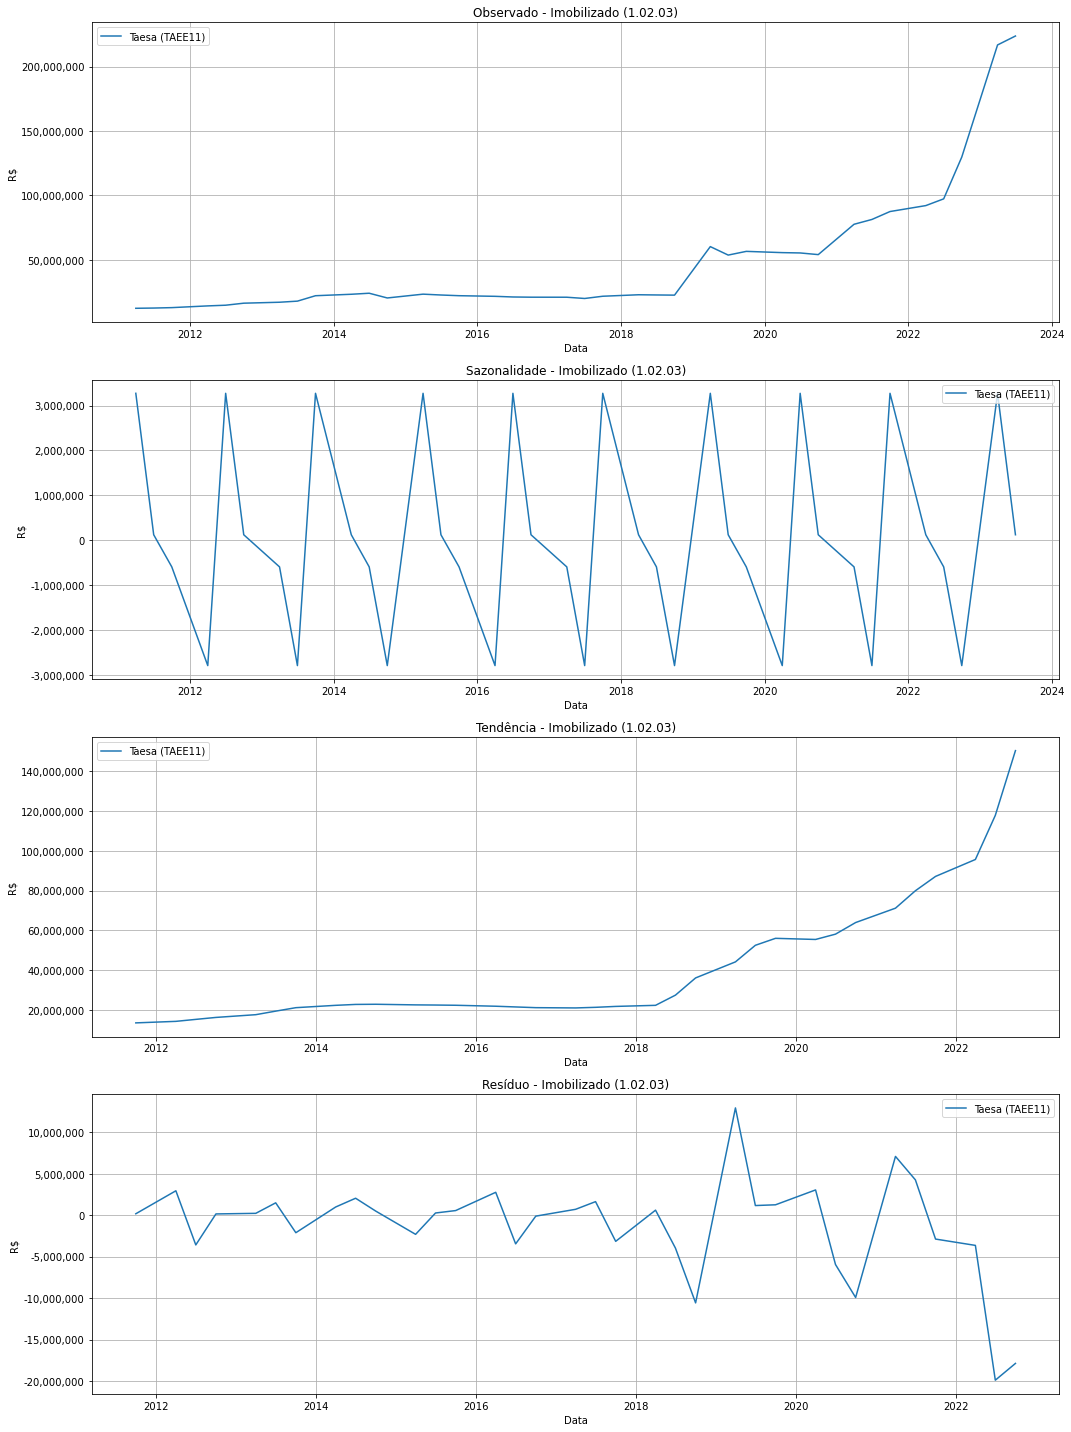


Checking if Imobilizado is stationary
ADF Statistic: 3.7724502564448223
ADF p-value: 1.0
Conclusion: The time series is NOT stationary

account
{'code': '1.02.03', 'name': 'Imobilizado', 'stationary': False, 'diff_count': 0}




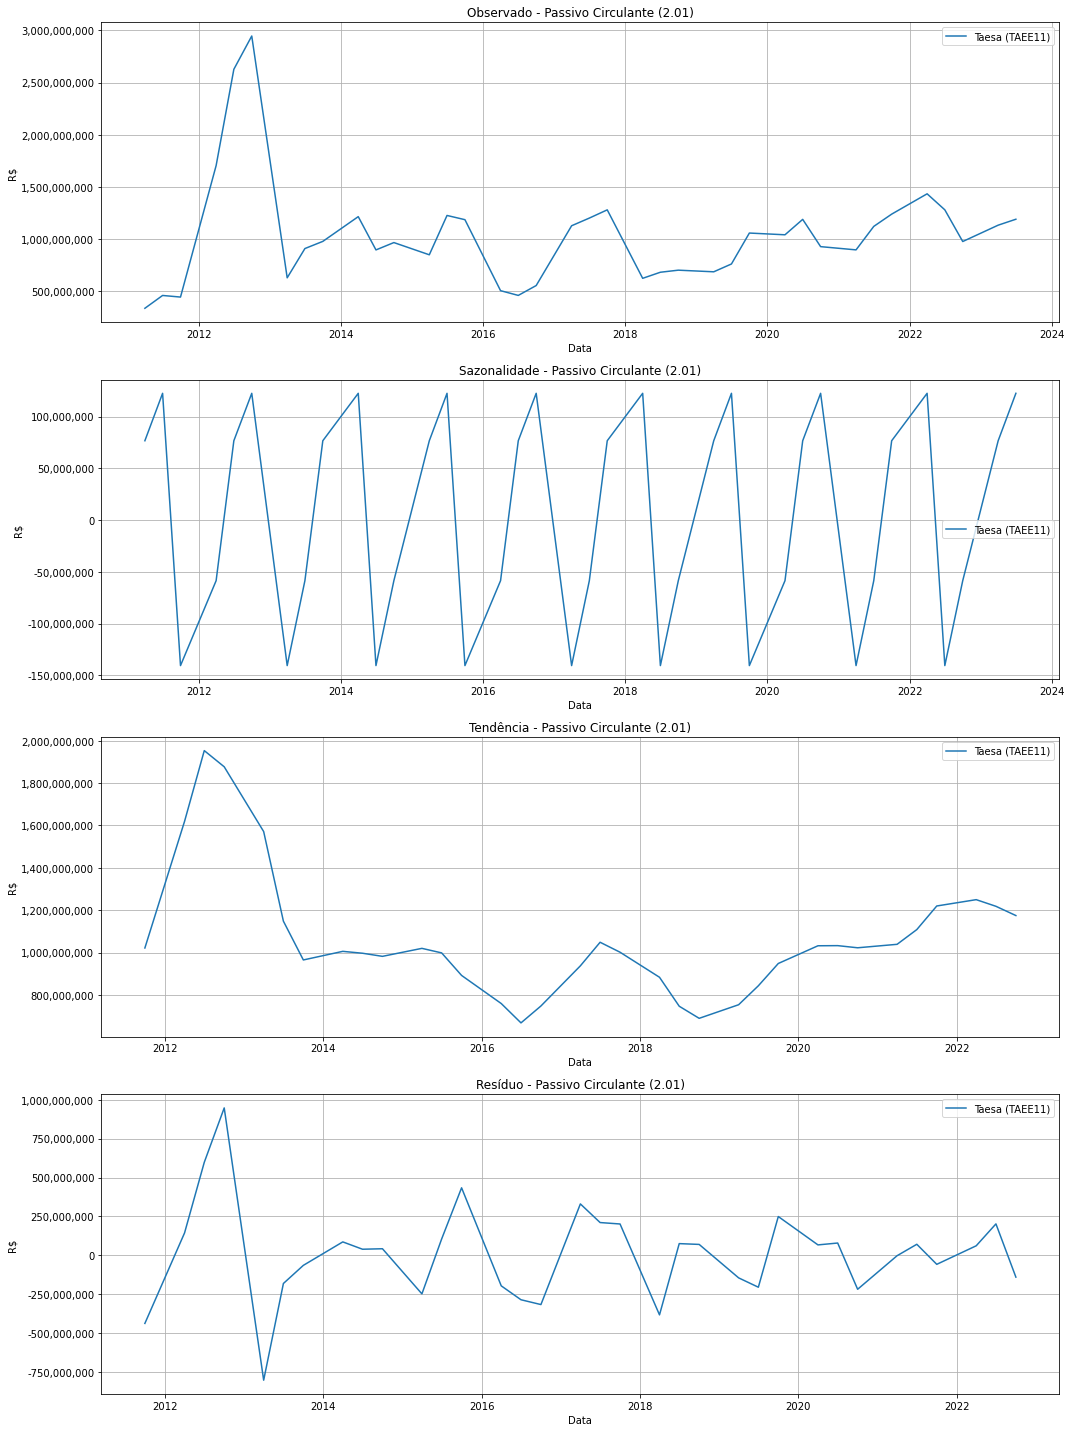


Checking if Passivo Circulante is stationary
ADF Statistic: -2.101012922202895
ADF p-value: 0.2441074955129125
Conclusion: The time series is NOT stationary

account
{'code': '2.01', 'name': 'Passivo Circulante', 'stationary': False, 'diff_count': 0}




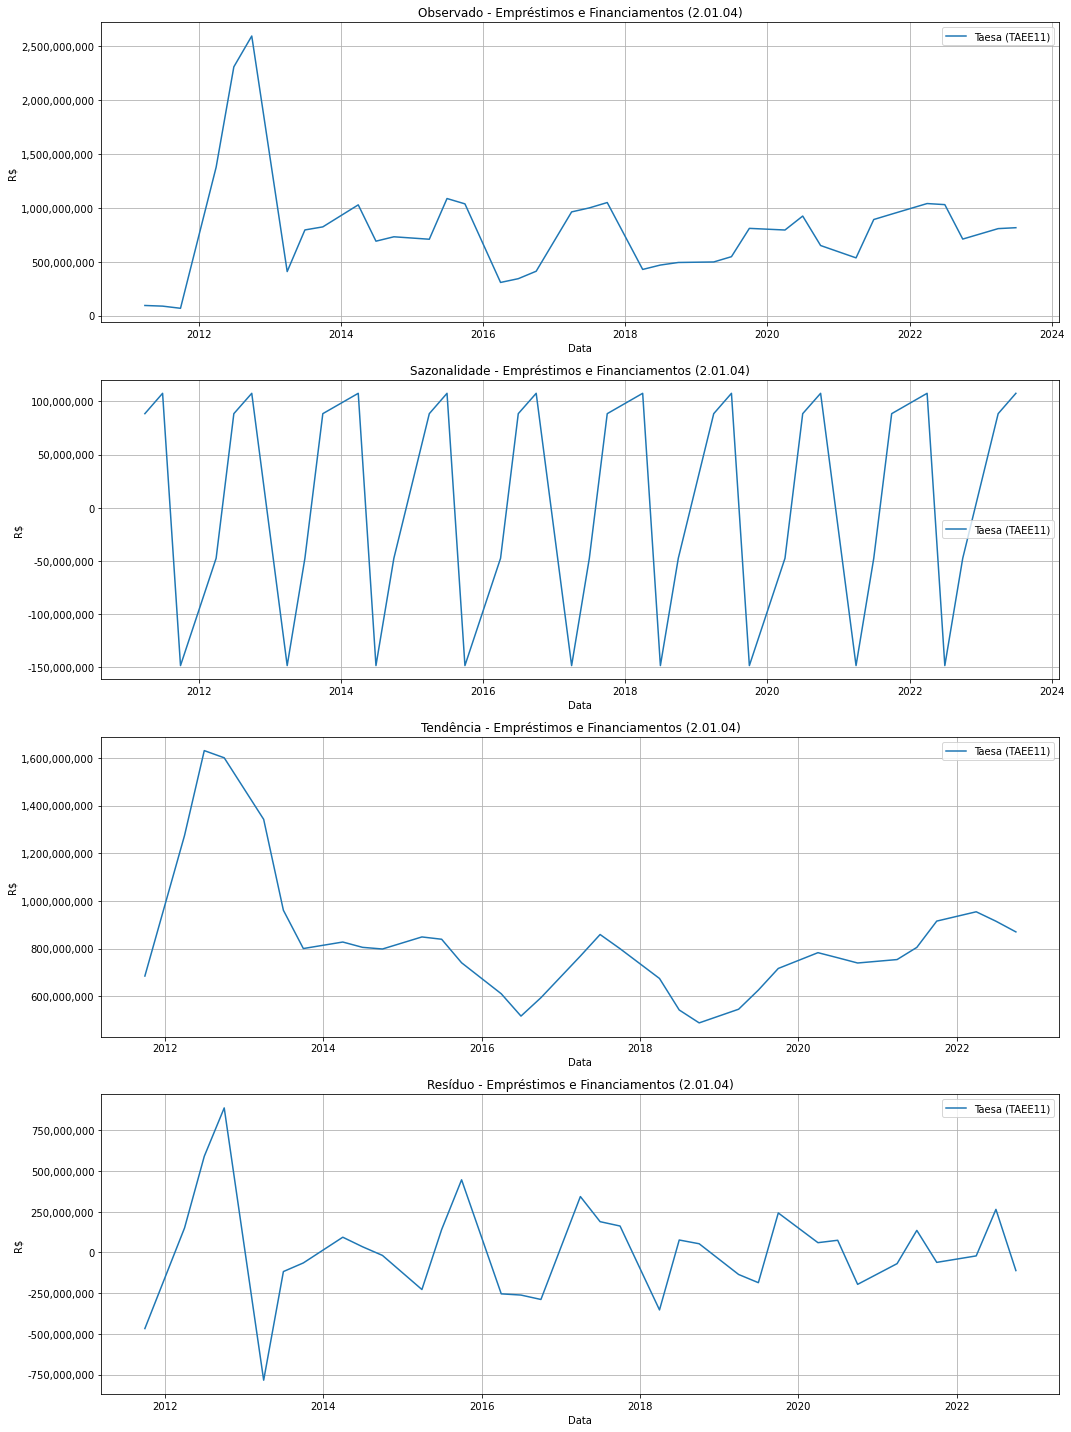


Checking if Empréstimos e Financiamentos is stationary
ADF Statistic: -2.796039411044252
ADF p-value: 0.058841740922901696
Conclusion: The time series is NOT stationary

account
{'code': '2.01.04', 'name': 'Empréstimos e Financiamentos', 'stationary': False, 'diff_count': 0}




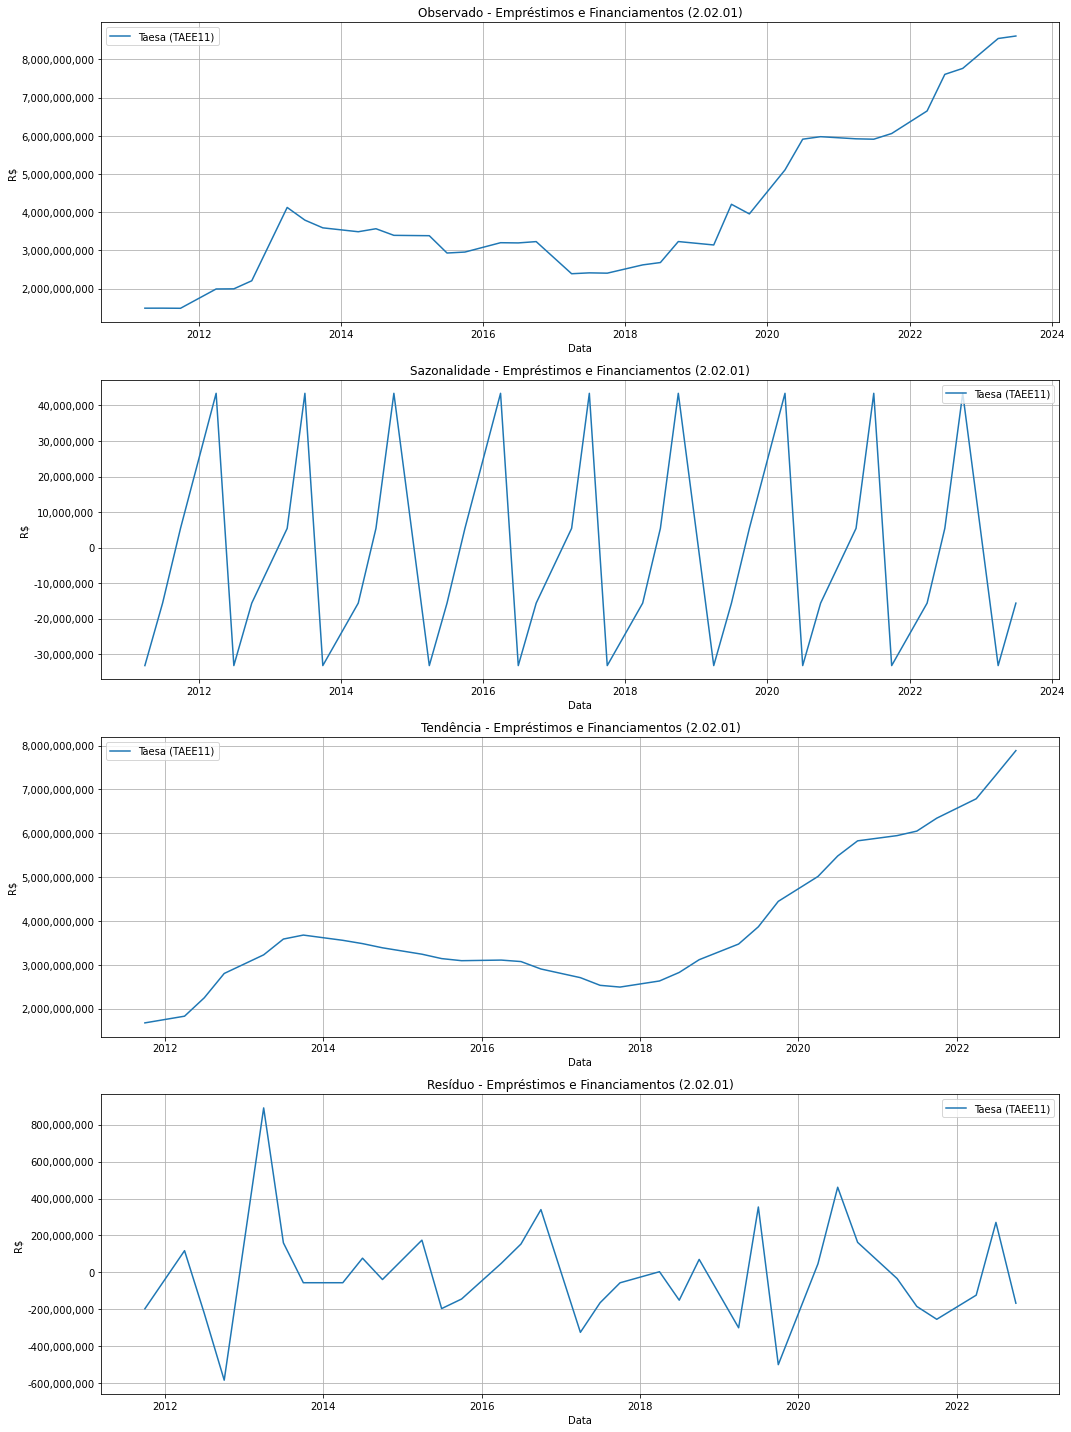


Checking if Empréstimos e Financiamentos is stationary
ADF Statistic: 0.51626276779643
ADF p-value: 0.9853590975005982
Conclusion: The time series is NOT stationary

account
{'code': '2.02.01', 'name': 'Empréstimos e Financiamentos', 'stationary': False, 'diff_count': 0}




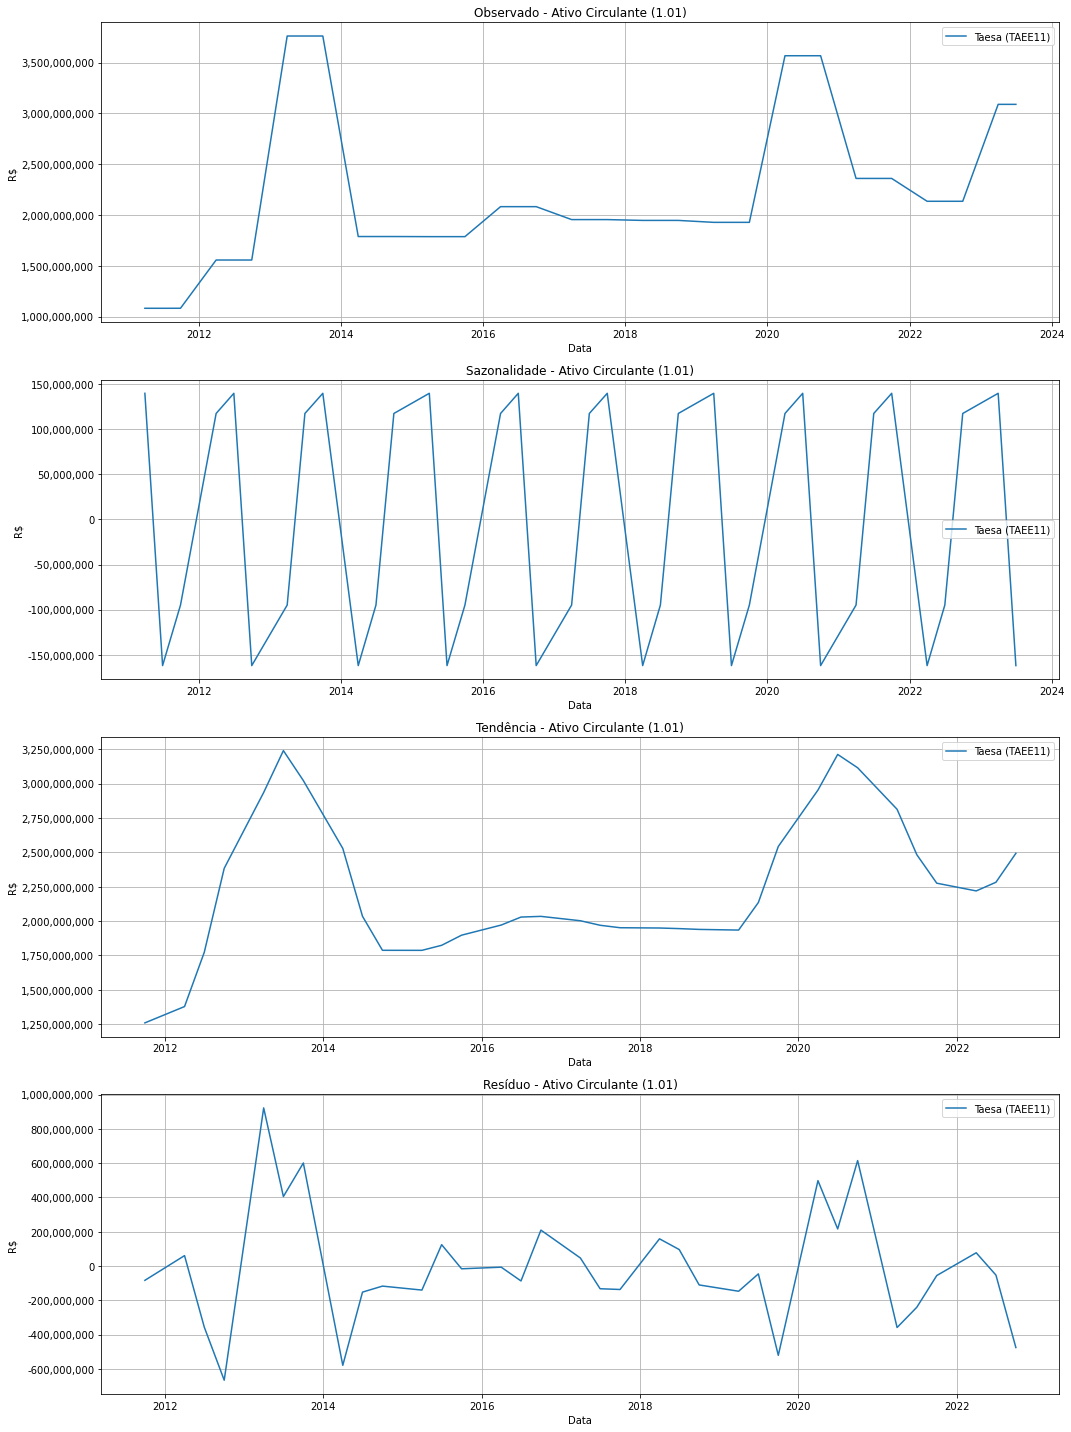


Checking if Ativo Circulante is stationary
ADF Statistic: -2.819591976020373
ADF p-value: 0.05552923246803539
Conclusion: The time series is NOT stationary

account
{'code': '1.01', 'name': 'Ativo Circulante', 'stationary': False, 'diff_count': 0}




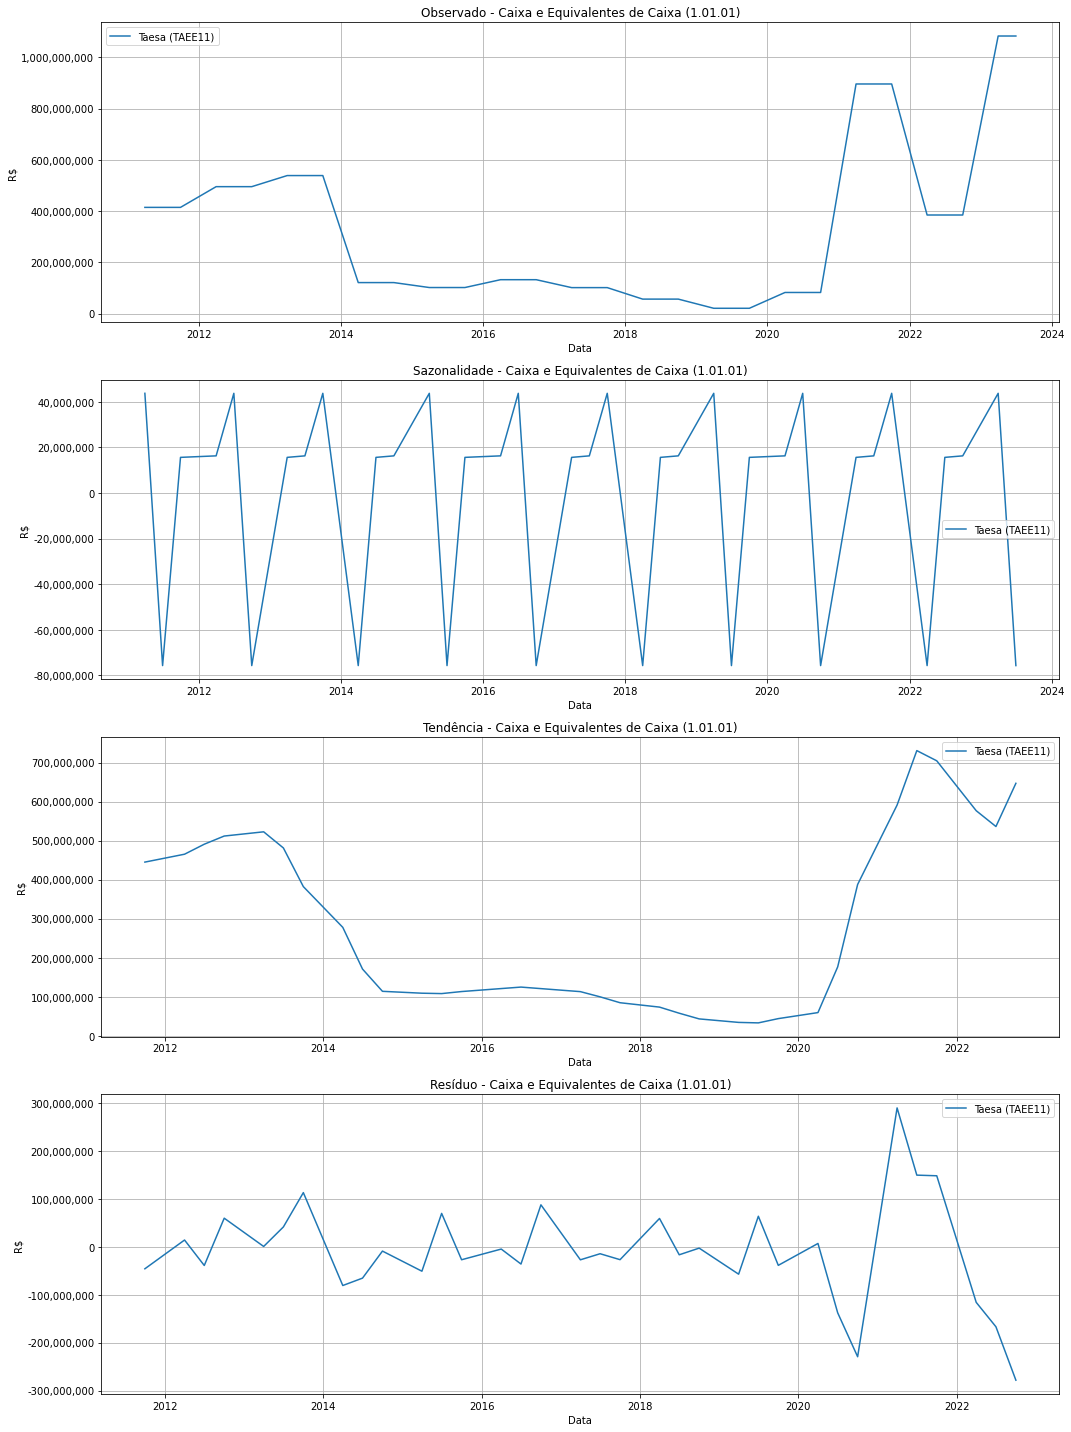


Checking if Caixa e Equivalentes de Caixa is stationary
ADF Statistic: -0.5430481586133618
ADF p-value: 0.883338687094362
Conclusion: The time series is NOT stationary

account
{'code': '1.01.01', 'name': 'Caixa e Equivalentes de Caixa', 'stationary': False, 'diff_count': 0}




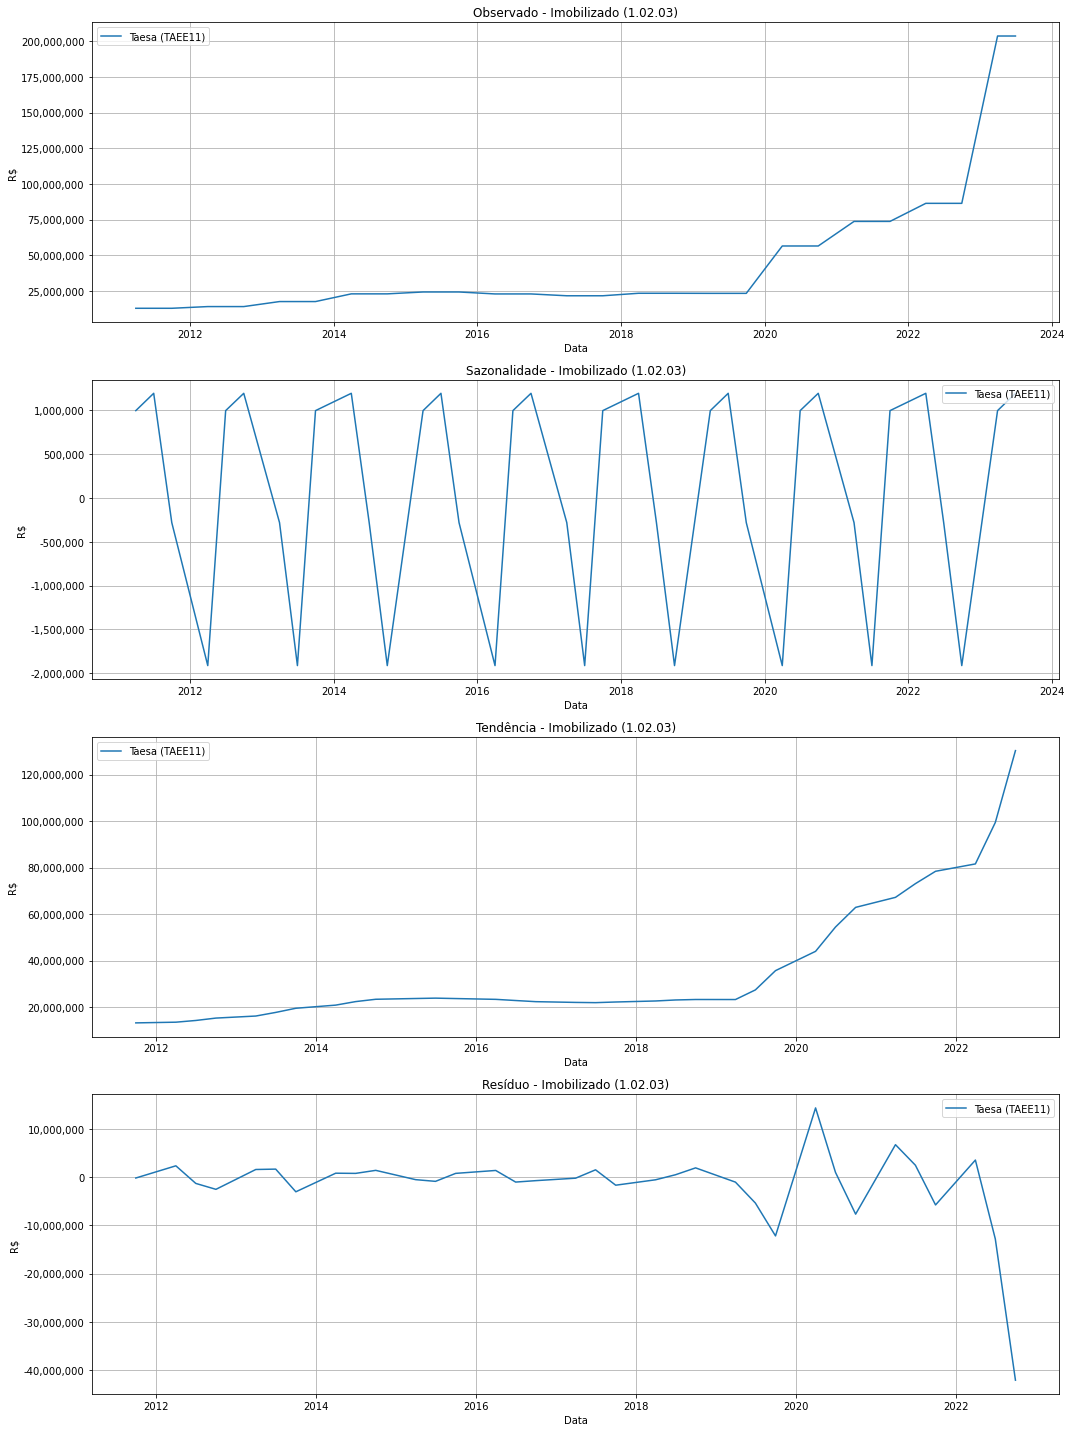


Checking if Imobilizado is stationary
ADF Statistic: 1.3489000643979918
ADF p-value: 0.9968691757790505
Conclusion: The time series is NOT stationary

account
{'code': '1.02.03', 'name': 'Imobilizado', 'stationary': False, 'diff_count': 0}




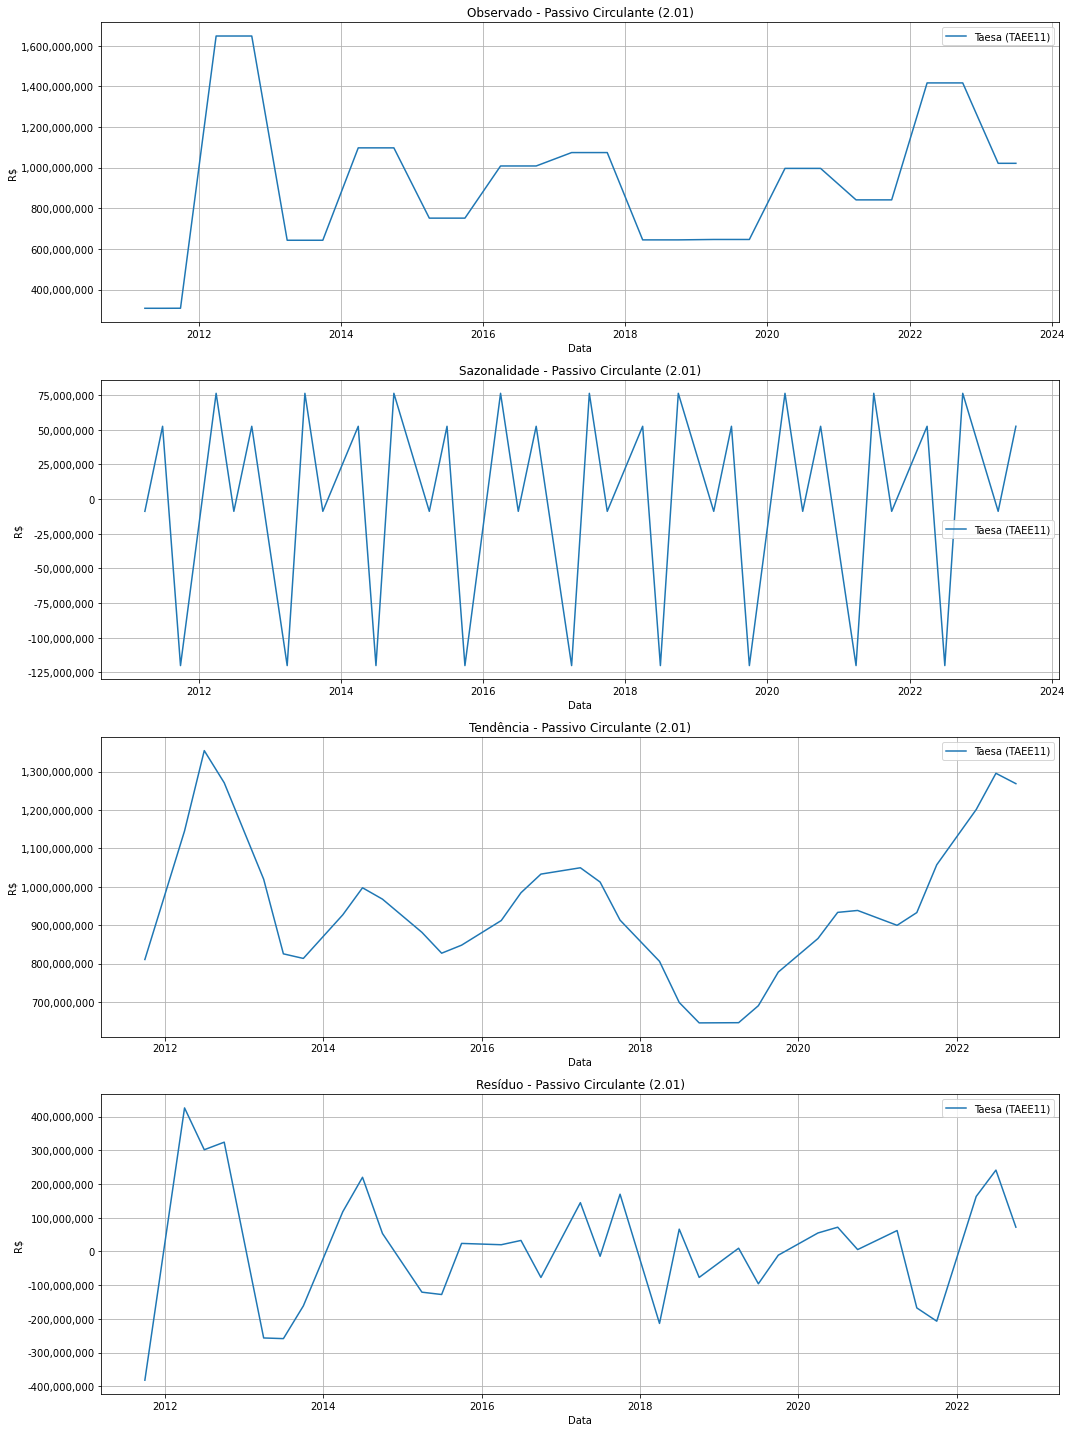


Checking if Passivo Circulante is stationary
ADF Statistic: -1.6159908001270424
ADF p-value: 0.47483178359663175
Conclusion: The time series is NOT stationary

account
{'code': '2.01', 'name': 'Passivo Circulante', 'stationary': False, 'diff_count': 0}




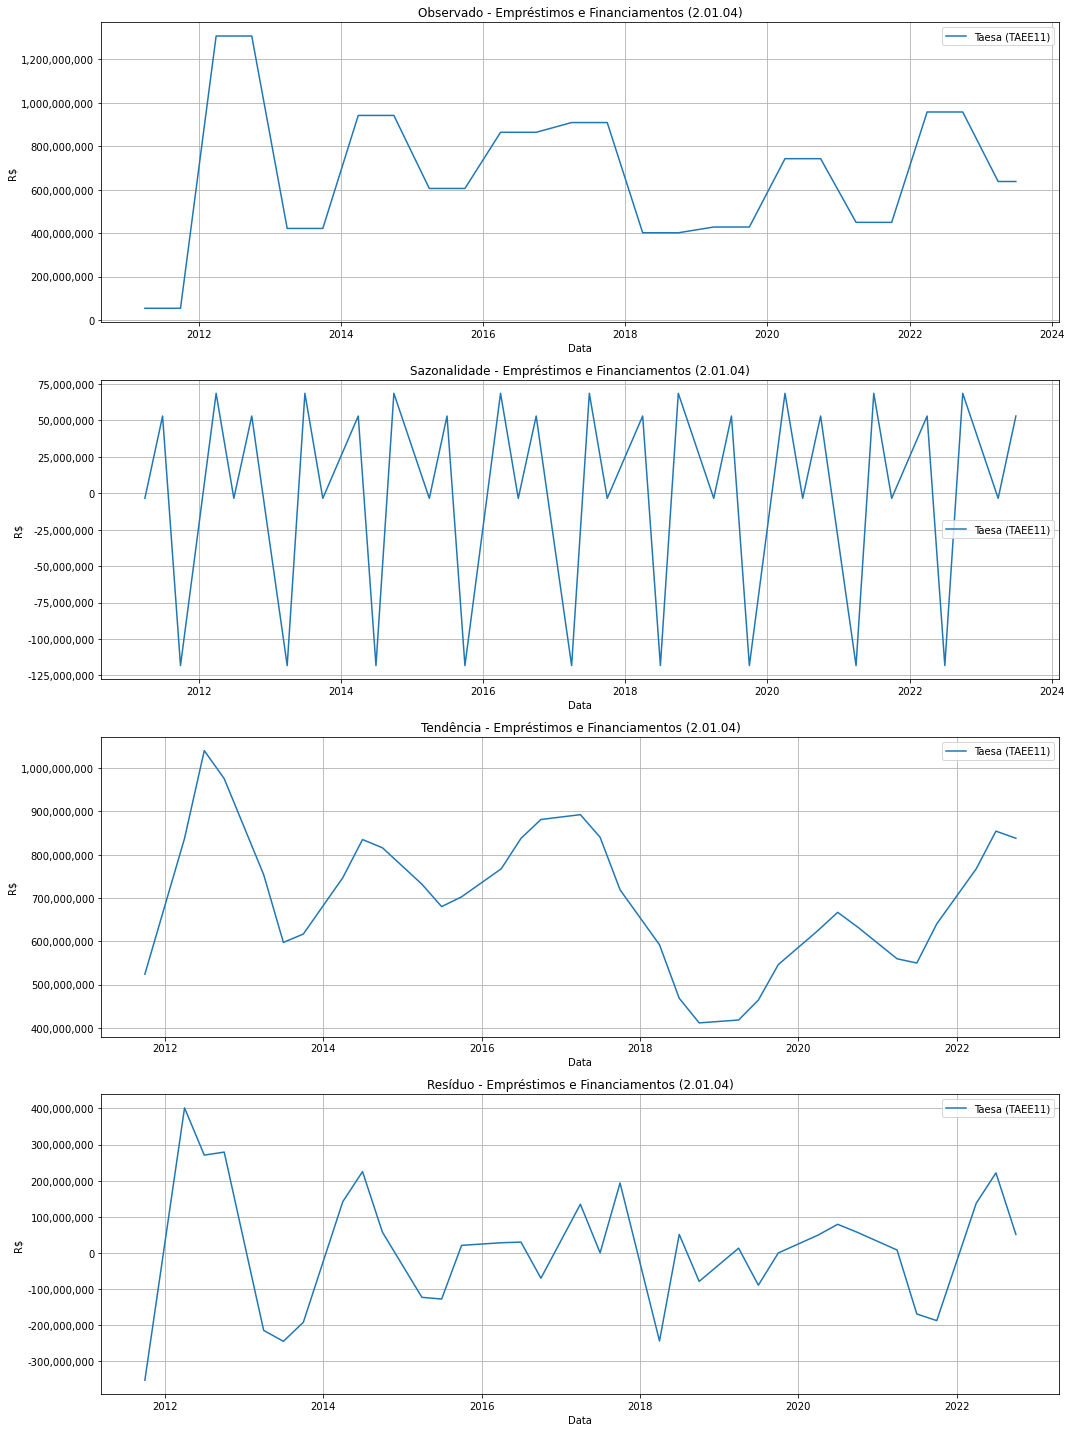


Checking if Empréstimos e Financiamentos is stationary
ADF Statistic: -1.9767209836030832
ADF p-value: 0.2968724754411226
Conclusion: The time series is NOT stationary

account
{'code': '2.01.04', 'name': 'Empréstimos e Financiamentos', 'stationary': False, 'diff_count': 0}




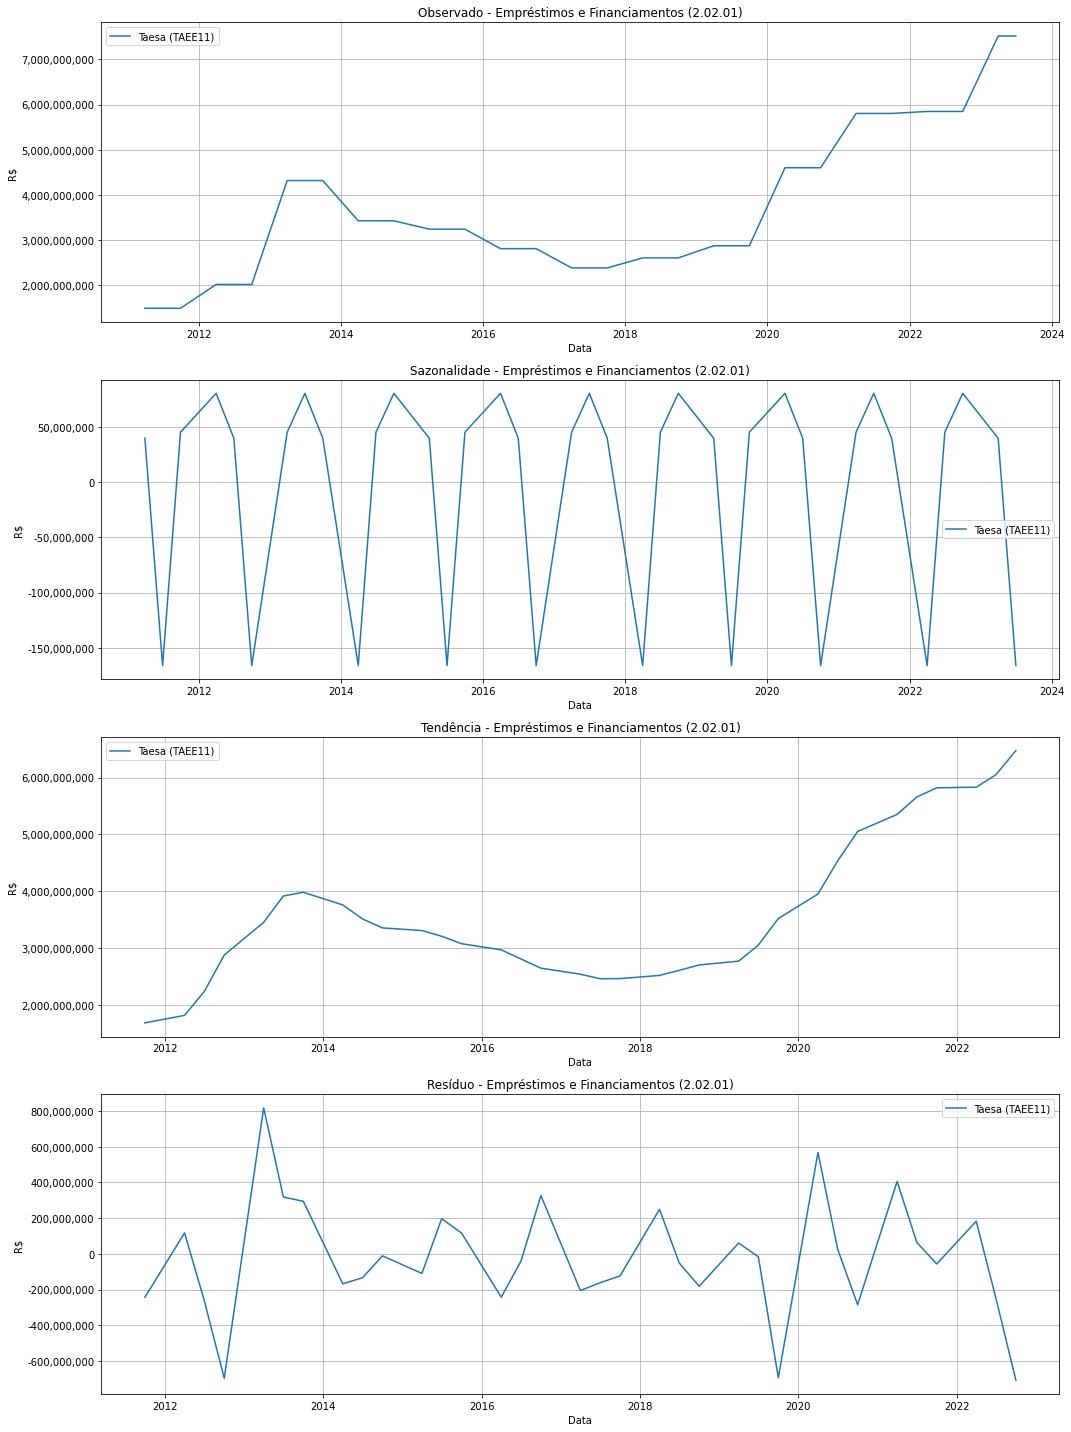


Checking if Empréstimos e Financiamentos is stationary
ADF Statistic: -0.24805236484719123
ADF p-value: 0.932546234618134
Conclusion: The time series is NOT stationary

account
{'code': '2.02.01', 'name': 'Empréstimos e Financiamentos', 'stationary': False, 'diff_count': 0}




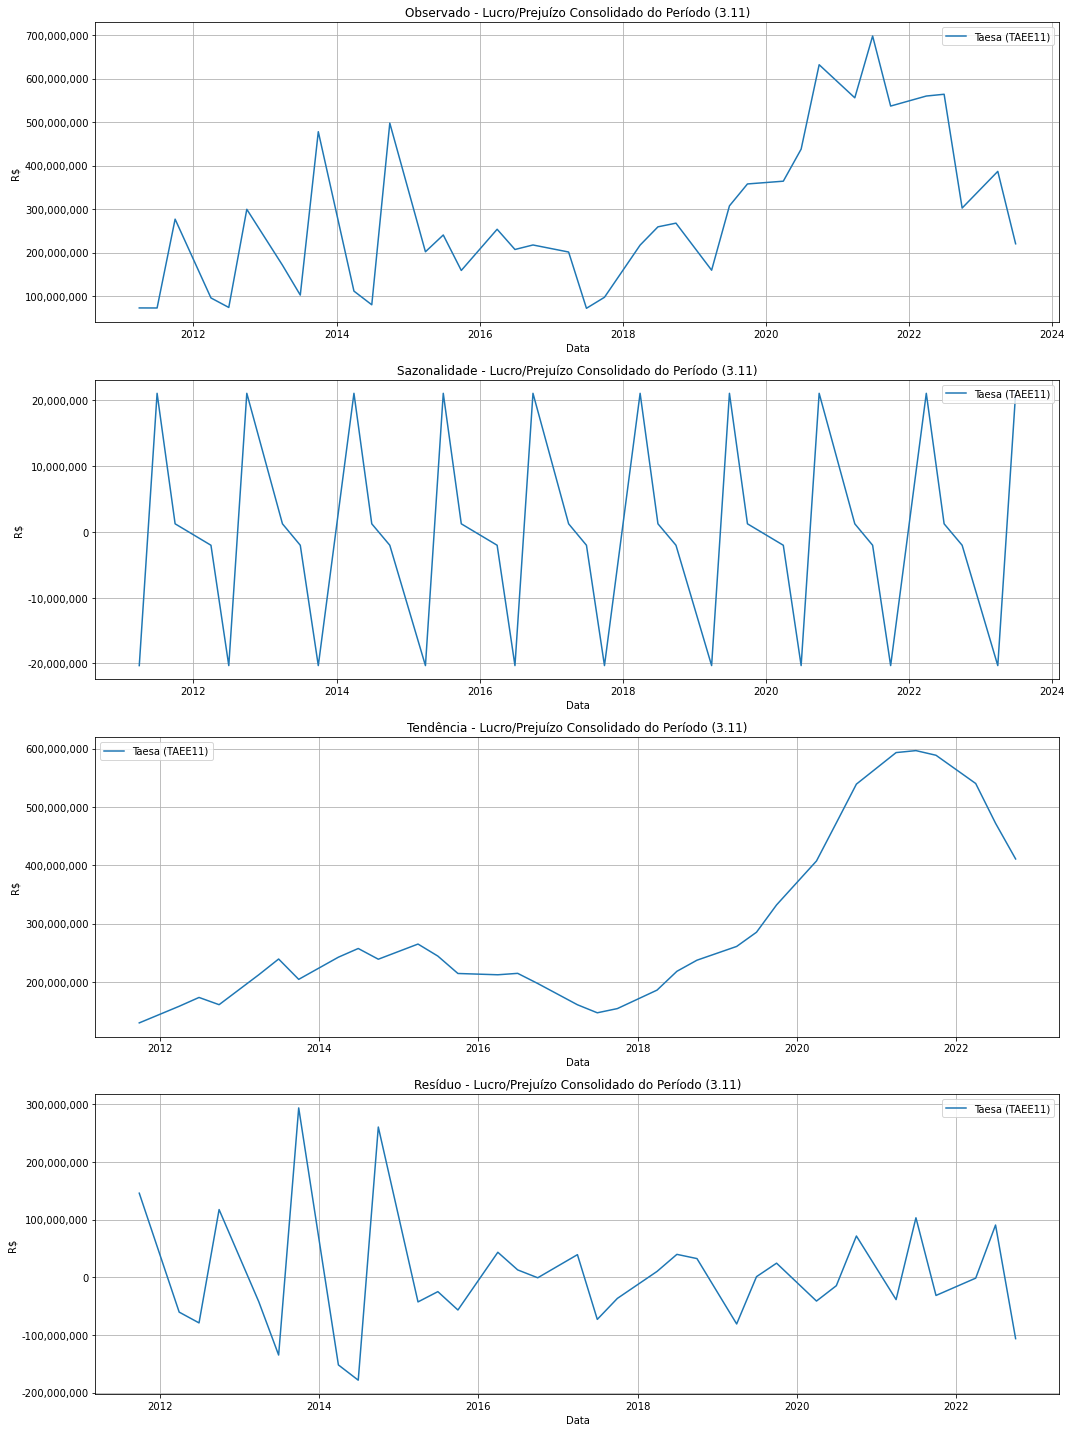


Checking if Lucro/Prejuízo Consolidado do Período is stationary
ADF Statistic: -2.9910162594886063
ADF p-value: 0.035741928590166214
Conclusion: The time series is stationary

account
{'code': '3.11', 'name': 'Lucro/Prejuízo Consolidado do Período', 'stationary': True, 'diff_count': 0}




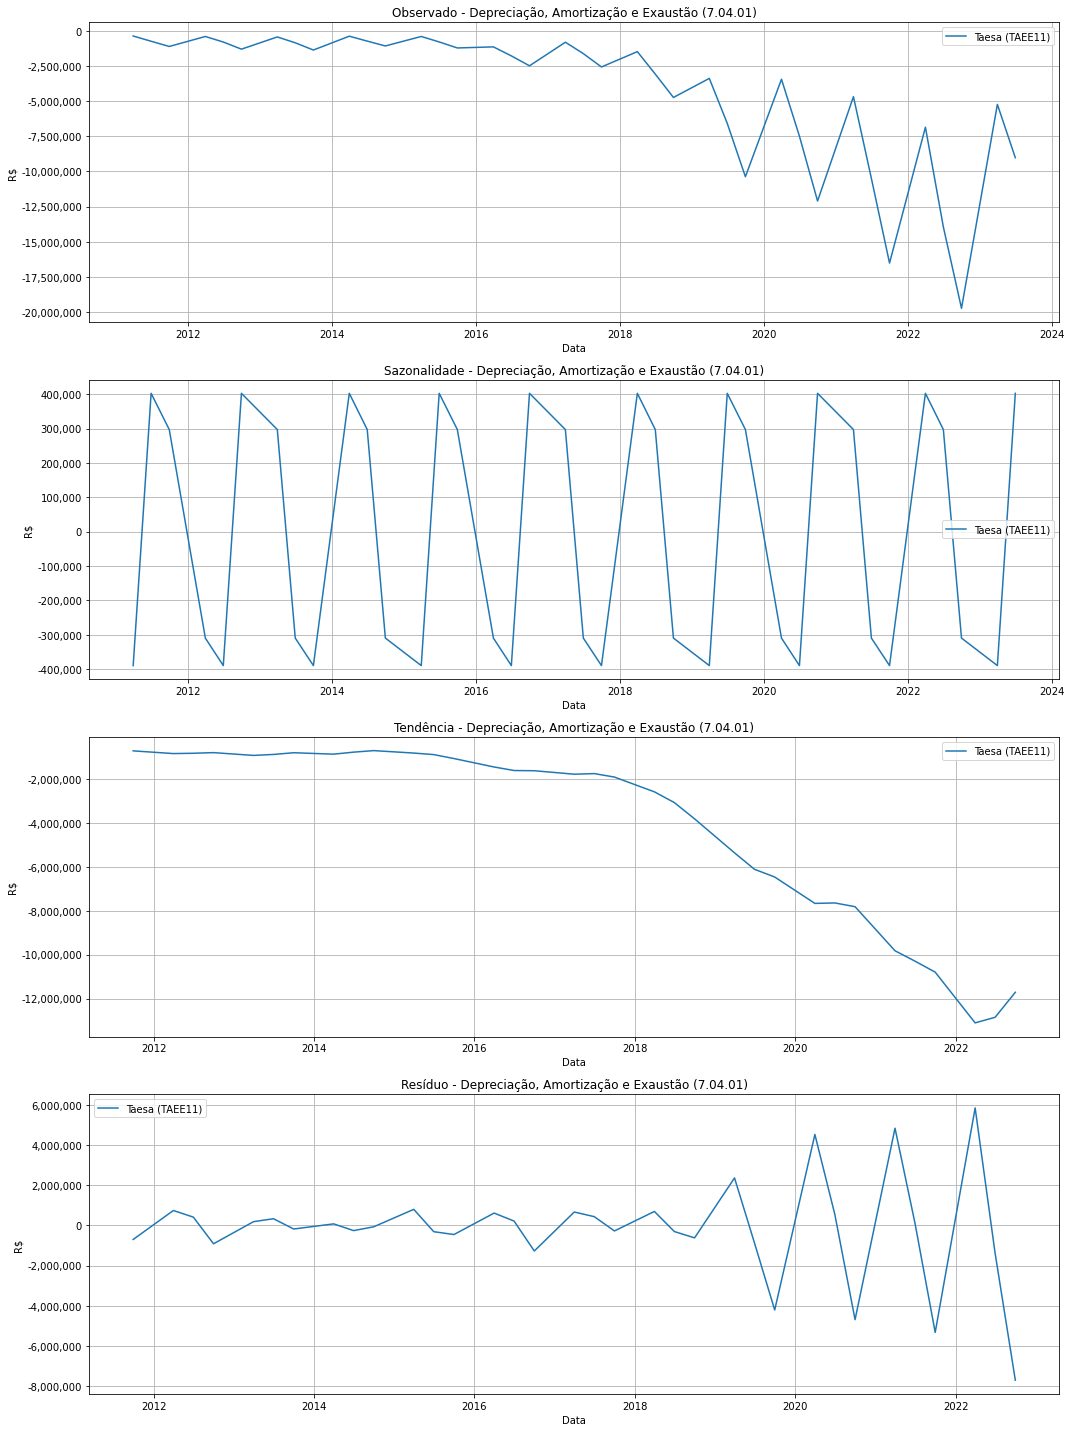


Checking if Depreciação, Amortização e Exaustão is stationary
ADF Statistic: -3.001015237093006
ADF p-value: 0.03479969861682131
Conclusion: The time series is stationary

account
{'code': '7.04.01', 'name': 'Depreciação, Amortização e Exaustão', 'stationary': True, 'diff_count': 0}




In [35]:
import pandas as pd
import re
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


# thousand separator
formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
P_VALUE = 0.05

# reading data
df_pivot = readCsv('pivot', '.', 'DT_REFER', 'Q')


def print_graph(size, index, data, company, title, account):
    plt.subplot(size, 1, index)
    plt.plot(data, label=f"{company['name']} ({company['ticker']})")
    plt.title(f"{title} - {account['name']} ({account['code']})")
    plt.xlabel('Data')
    plt.ylabel('R$')
    plt.legend(loc='best')
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.grid(True)


def check_stationarity(data, name):
    print(f'\nChecking if {name} is stationary')
    # Performing the Augmented Dickey-Fuller test:
    adf_result = adfuller(data)
    adf_statistic, adf_p_value = adf_result[0], adf_result[1]
    print('ADF Statistic:', adf_statistic)
    print('ADF p-value:', adf_p_value)

    is_stationary = adf_p_value <= P_VALUE
    if is_stationary:
        #print("Conclusão: A série é estacionária.")
        print("Conclusion: The time series is stationary")
    else:
        #print("Conclusão: A série NÃO é estacionária.")
        print("Conclusion: The time series is NOT stationary")
    return is_stationary


def decompose_and_print(df, accounts):
    for company_code in companies:
        company_data = df[df['CD_CVM'] == company_code]
        company = companies[company_code]

        for account_key in accounts:
            account = accounts[account_key]

            # 4 = quarter division
            decomposition = seasonal_decompose(company_data[account_key], model='additive', period=4)

            plt.figure(figsize=(15, 20))

            print_graph(4, 1, decomposition.observed, company, 'Observado', account)
            print_graph(4, 2, decomposition.seasonal, company, 'Sazonalidade', account)
            print_graph(4, 3, decomposition.trend, company, 'Tendência', account)
            print_graph(4, 4, decomposition.resid, company, 'Resíduo', account)

            plt.tight_layout()
            plt.grid(True)
            plt.show()


            account['stationary'] = check_stationarity(company_data[account_key], account['name'])

            print('\naccount')
            print(account)
            print('\n')


decompose_and_print(df_pivot, accounts_to_calculate_fcfe)


#### 5.1.2 Making non-stationary series stationary



------------------------------------------------------------------

 before differentiation
{'code': '1.02.03', 'name': 'Imobilizado', 'stationary': False, 'diff_count': 0}

 after differentiation
{'code': '1.02.03', 'name': 'Imobilizado', 'stationary': False, 'diff_count': 2}


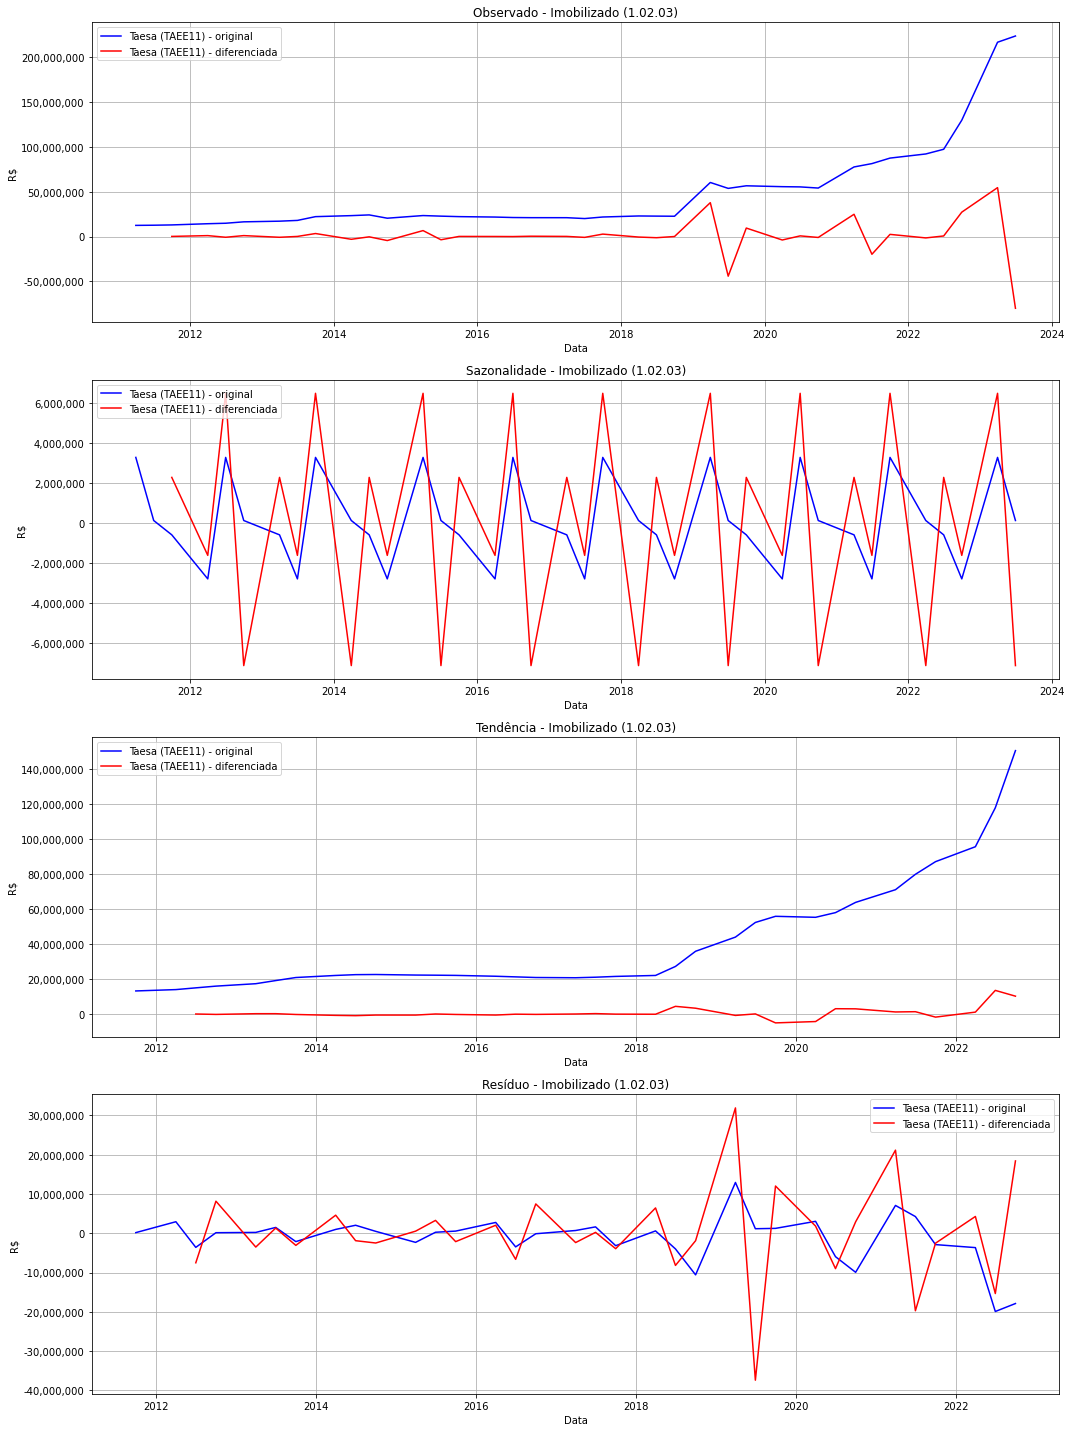


Checking if Imobilizado is stationary
ADF Statistic: -3.11353793326558
ADF p-value: 0.02556740799758976
Conclusion: The time series is stationary

account
{'code': '1.02.03', 'name': 'Imobilizado', 'stationary': True, 'diff_count': 2}




------------------------------------------------------------------

 before differentiation
{'code': '2.01', 'name': 'Passivo Circulante', 'stationary': False, 'diff_count': 0}

 after differentiation
{'code': '2.01', 'name': 'Passivo Circulante', 'stationary': False, 'diff_count': 2}


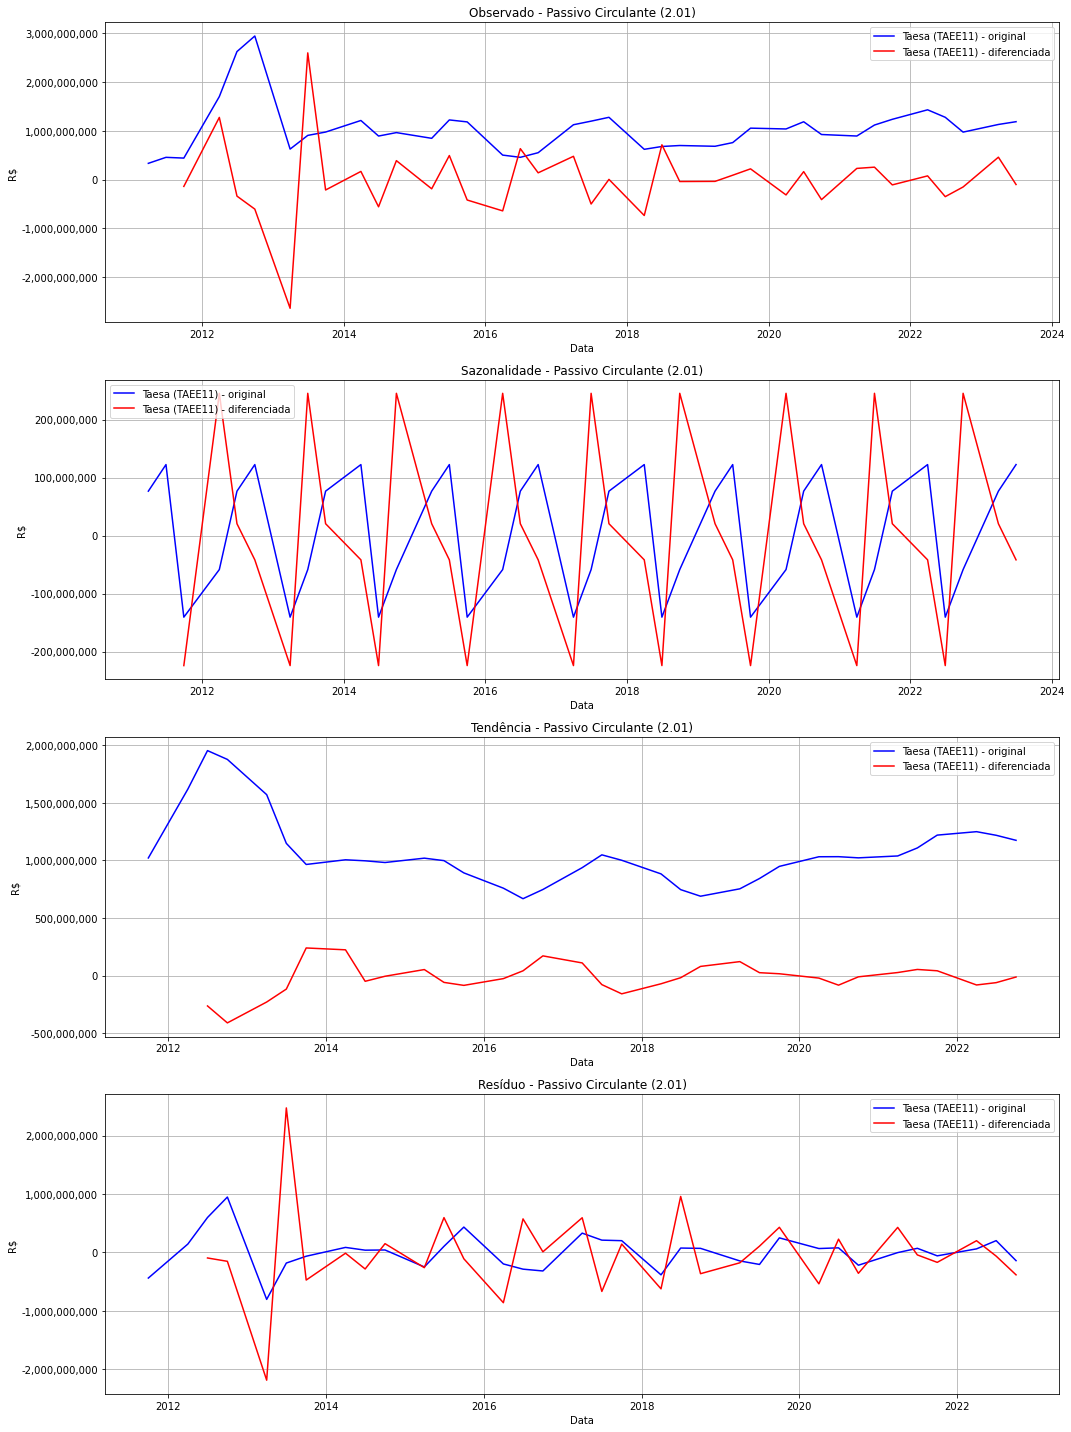


Checking if Passivo Circulante is stationary
ADF Statistic: -7.776214418430882
ADF p-value: 8.655524099270813e-12
Conclusion: The time series is stationary

account
{'code': '2.01', 'name': 'Passivo Circulante', 'stationary': True, 'diff_count': 2}




------------------------------------------------------------------

 before differentiation
{'code': '2.01.04', 'name': 'Empréstimos e Financiamentos', 'stationary': False, 'diff_count': 0}

 after differentiation
{'code': '2.01.04', 'name': 'Empréstimos e Financiamentos', 'stationary': False, 'diff_count': 2}


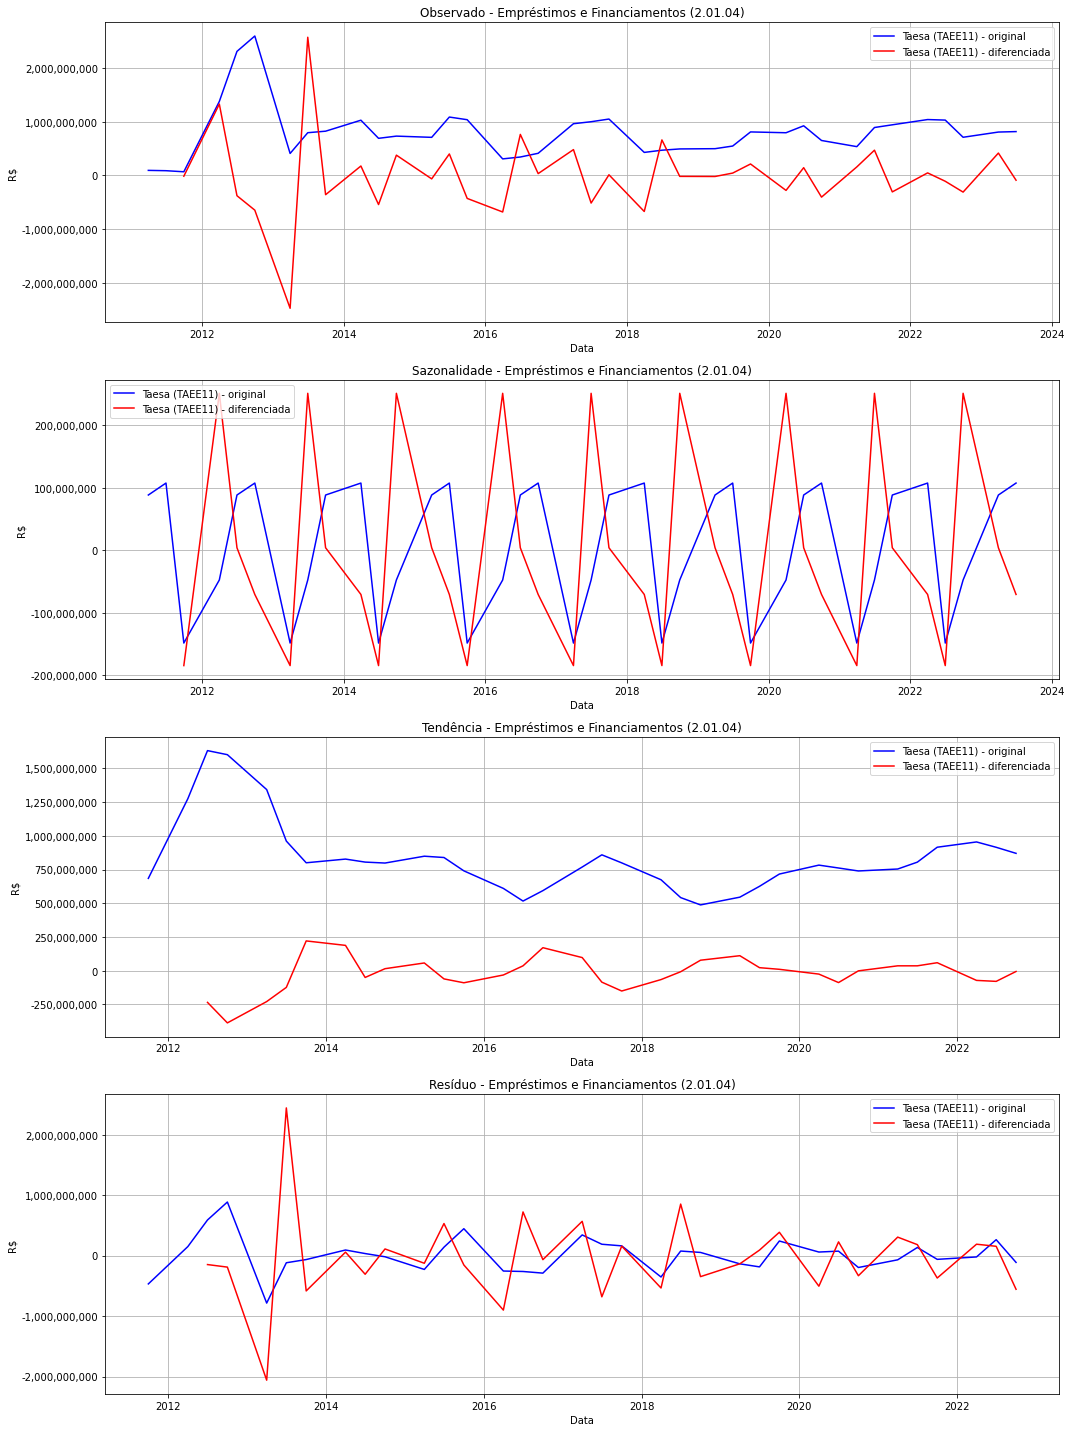


Checking if Empréstimos e Financiamentos is stationary
ADF Statistic: -7.994044955722799
ADF p-value: 2.4310268925590994e-12
Conclusion: The time series is stationary

account
{'code': '2.01.04', 'name': 'Empréstimos e Financiamentos', 'stationary': True, 'diff_count': 2}




------------------------------------------------------------------

 before differentiation
{'code': '2.02.01', 'name': 'Empréstimos e Financiamentos', 'stationary': False, 'diff_count': 0}

 after differentiation
{'code': '2.02.01', 'name': 'Empréstimos e Financiamentos', 'stationary': False, 'diff_count': 1}


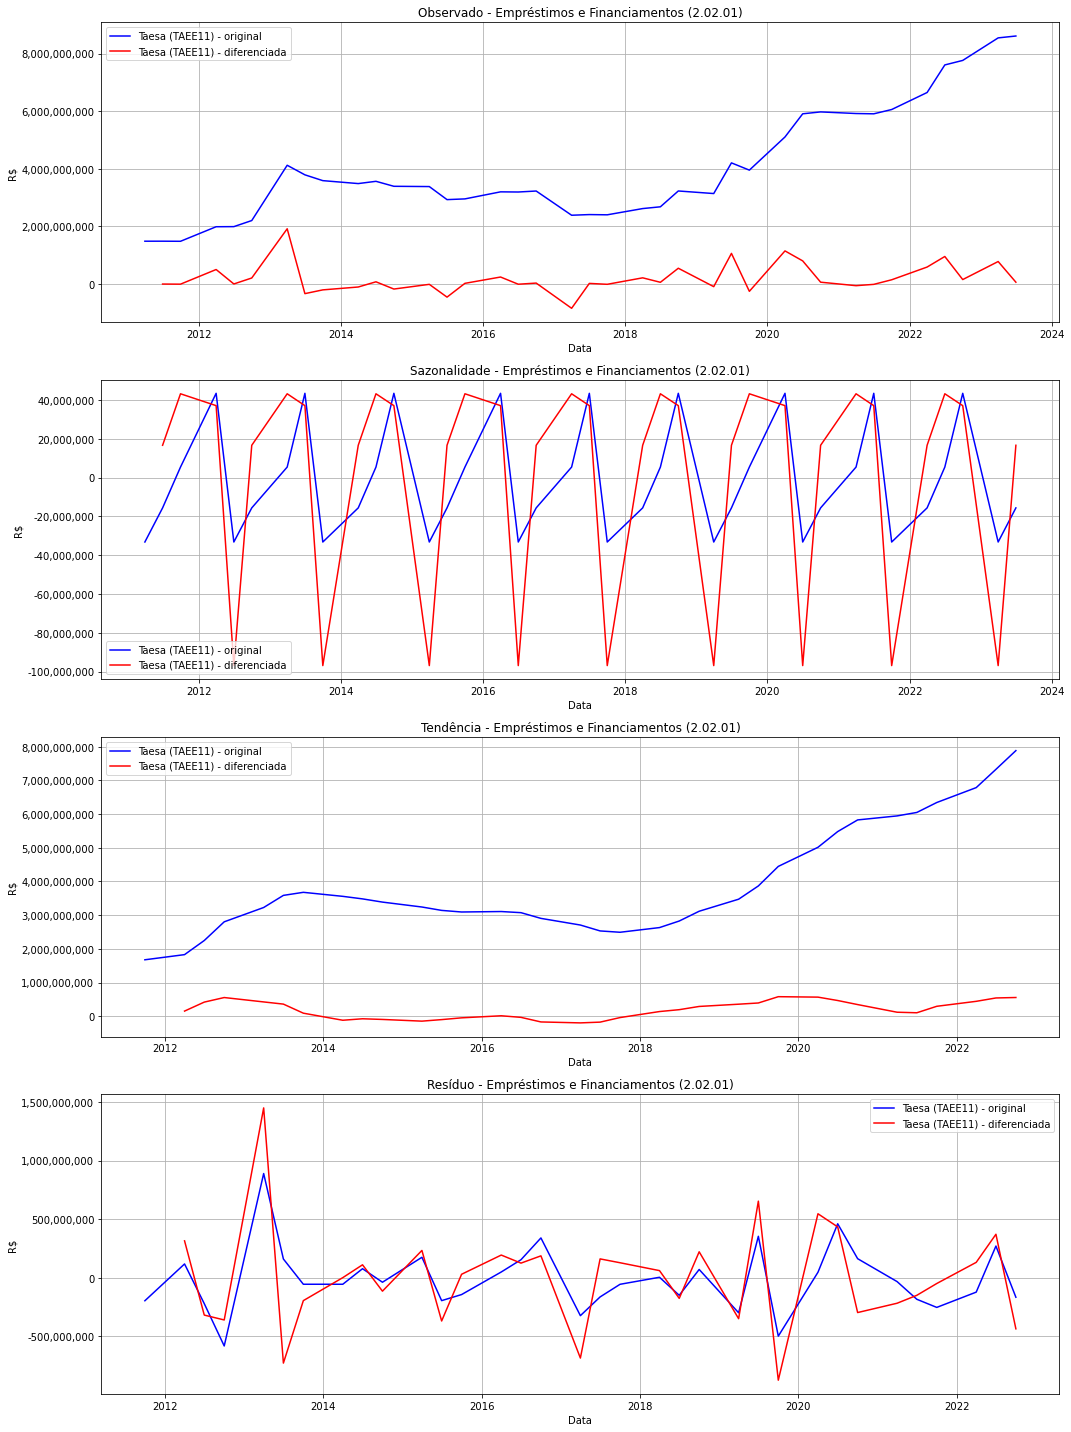


Checking if Empréstimos e Financiamentos is stationary
ADF Statistic: -3.581063424568307
ADF p-value: 0.006133546768330533
Conclusion: The time series is stationary

account
{'code': '2.02.01', 'name': 'Empréstimos e Financiamentos', 'stationary': True, 'diff_count': 1}




------------------------------------------------------------------

 before differentiation
{'code': '1.01', 'name': 'Ativo Circulante', 'stationary': False, 'diff_count': 0}

 after differentiation
{'code': '1.01', 'name': 'Ativo Circulante', 'stationary': False, 'diff_count': 1}


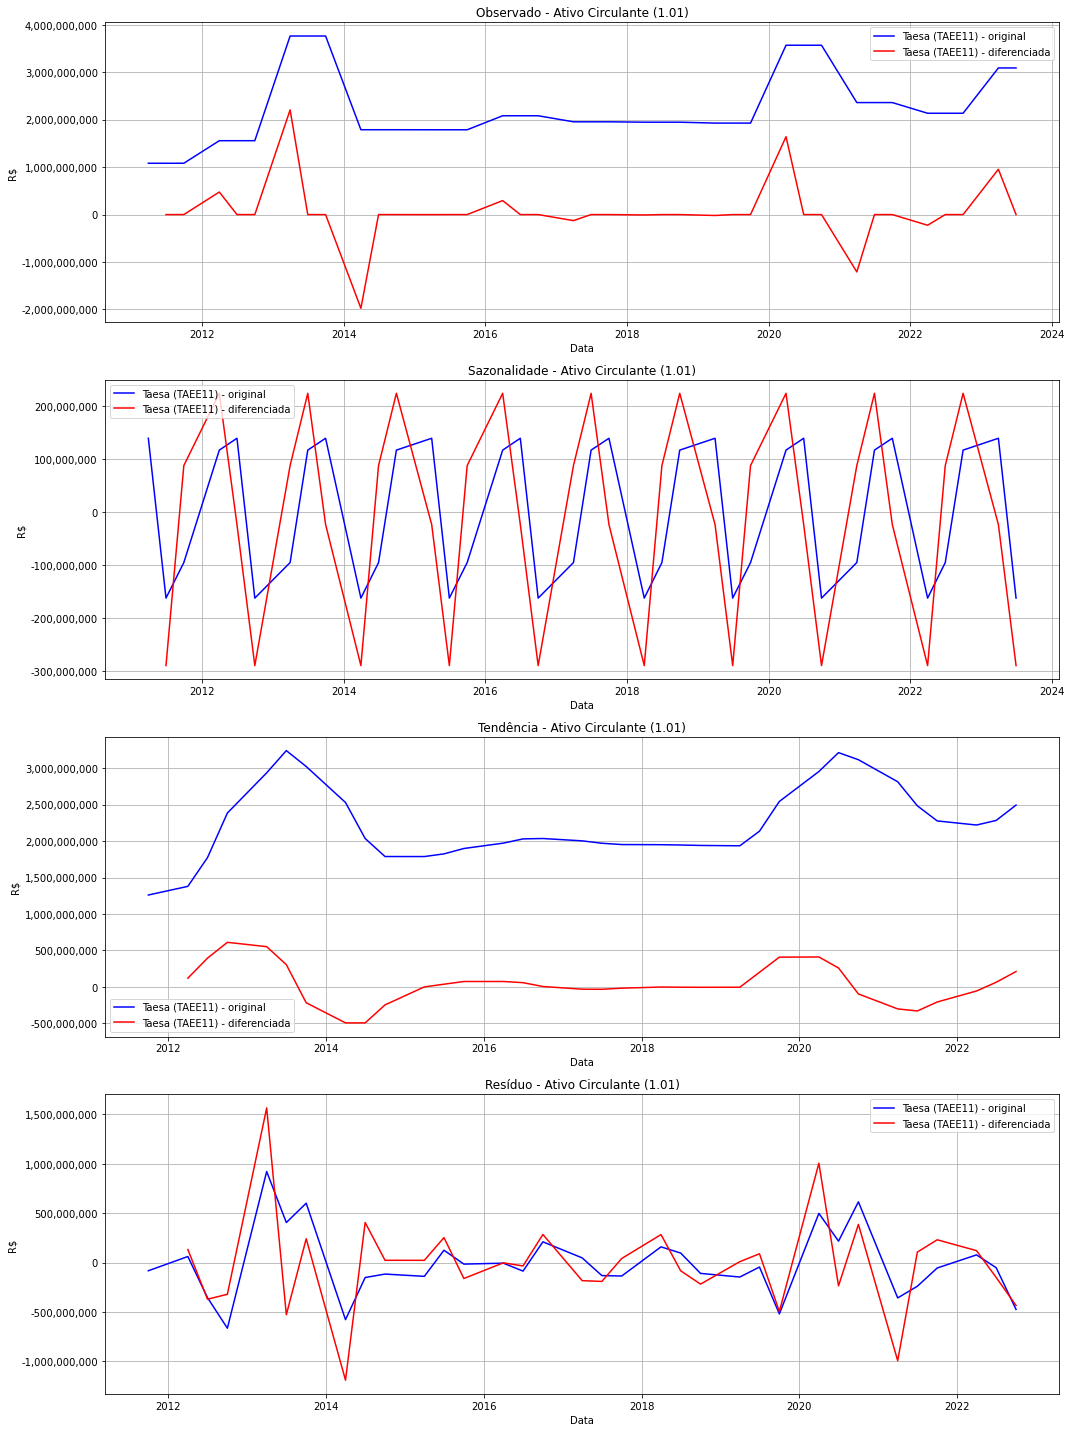


Checking if Ativo Circulante is stationary
ADF Statistic: -6.701694802523442
ADF p-value: 3.874758746723181e-09
Conclusion: The time series is stationary

account
{'code': '1.01', 'name': 'Ativo Circulante', 'stationary': True, 'diff_count': 1}




------------------------------------------------------------------

 before differentiation
{'code': '1.01.01', 'name': 'Caixa e Equivalentes de Caixa', 'stationary': False, 'diff_count': 0}

 after differentiation
{'code': '1.01.01', 'name': 'Caixa e Equivalentes de Caixa', 'stationary': False, 'diff_count': 1}


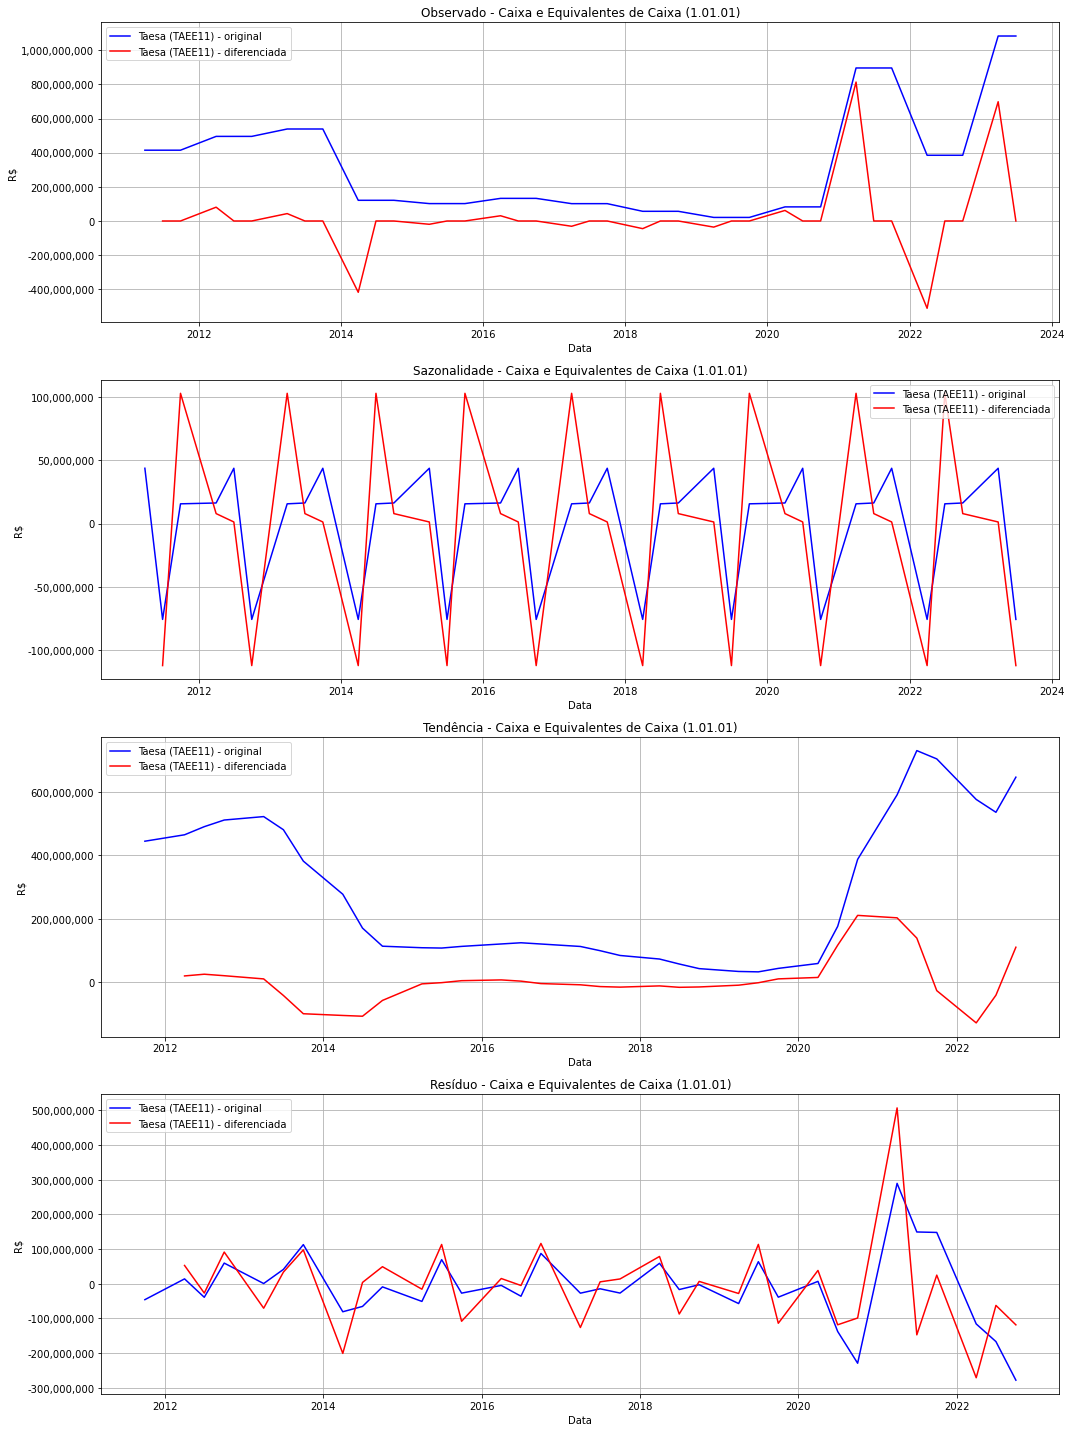


Checking if Caixa e Equivalentes de Caixa is stationary
ADF Statistic: -5.550936784036278
ADF p-value: 1.620444109530843e-06
Conclusion: The time series is stationary

account
{'code': '1.01.01', 'name': 'Caixa e Equivalentes de Caixa', 'stationary': True, 'diff_count': 1}




------------------------------------------------------------------

 before differentiation
{'code': '1.02.03', 'name': 'Imobilizado', 'stationary': False, 'diff_count': 0}

 after differentiation
{'code': '1.02.03', 'name': 'Imobilizado', 'stationary': False, 'diff_count': 3}


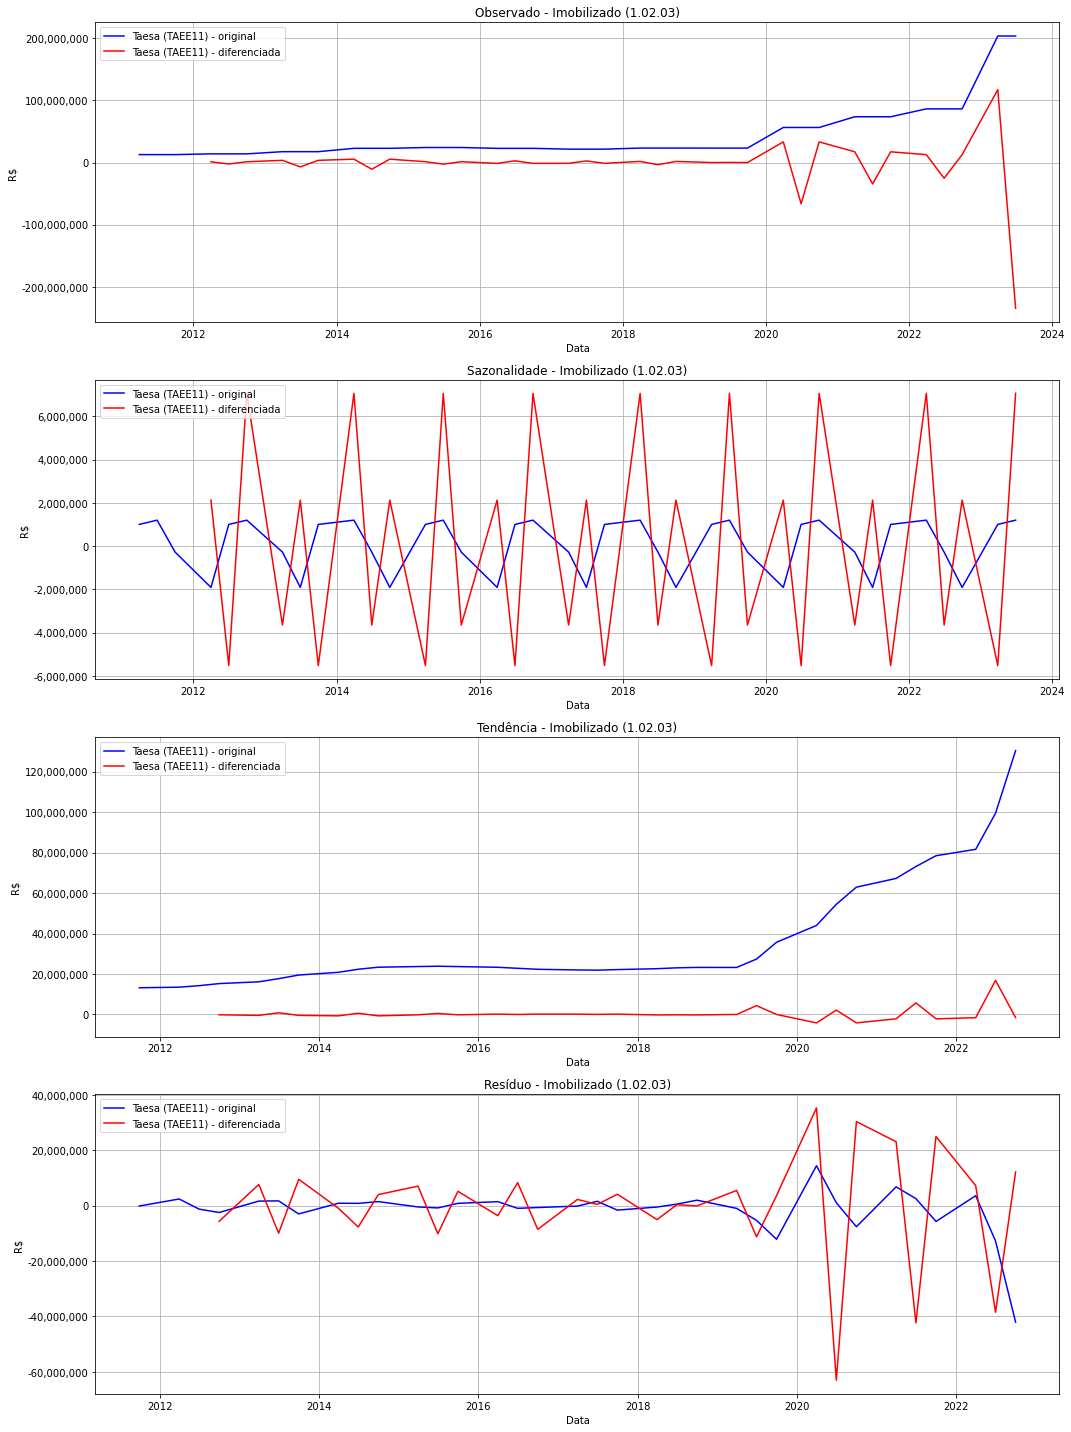


Checking if Imobilizado is stationary
ADF Statistic: -5.046915408442916
ADF p-value: 1.790673961536016e-05
Conclusion: The time series is stationary

account
{'code': '1.02.03', 'name': 'Imobilizado', 'stationary': True, 'diff_count': 3}




------------------------------------------------------------------

 before differentiation
{'code': '2.01', 'name': 'Passivo Circulante', 'stationary': False, 'diff_count': 0}

 after differentiation
{'code': '2.01', 'name': 'Passivo Circulante', 'stationary': False, 'diff_count': 1}


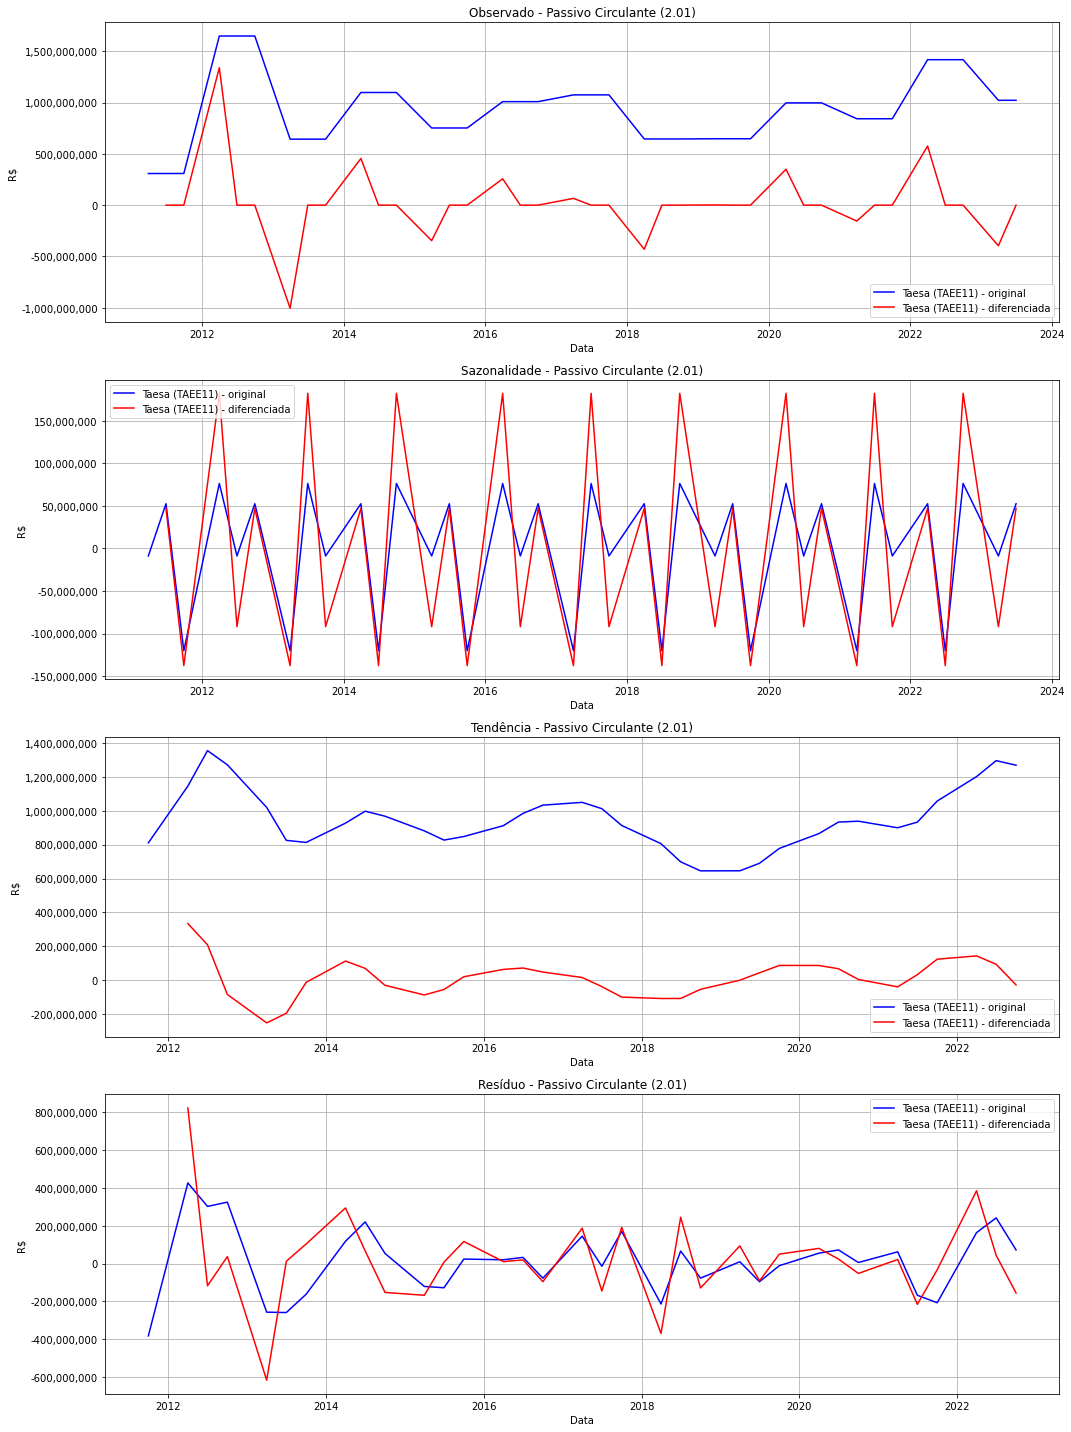


Checking if Passivo Circulante is stationary
ADF Statistic: -12.112897627235407
ADF p-value: 1.901274697062919e-22
Conclusion: The time series is stationary

account
{'code': '2.01', 'name': 'Passivo Circulante', 'stationary': True, 'diff_count': 1}




------------------------------------------------------------------

 before differentiation
{'code': '2.01.04', 'name': 'Empréstimos e Financiamentos', 'stationary': False, 'diff_count': 0}

 after differentiation
{'code': '2.01.04', 'name': 'Empréstimos e Financiamentos', 'stationary': False, 'diff_count': 1}


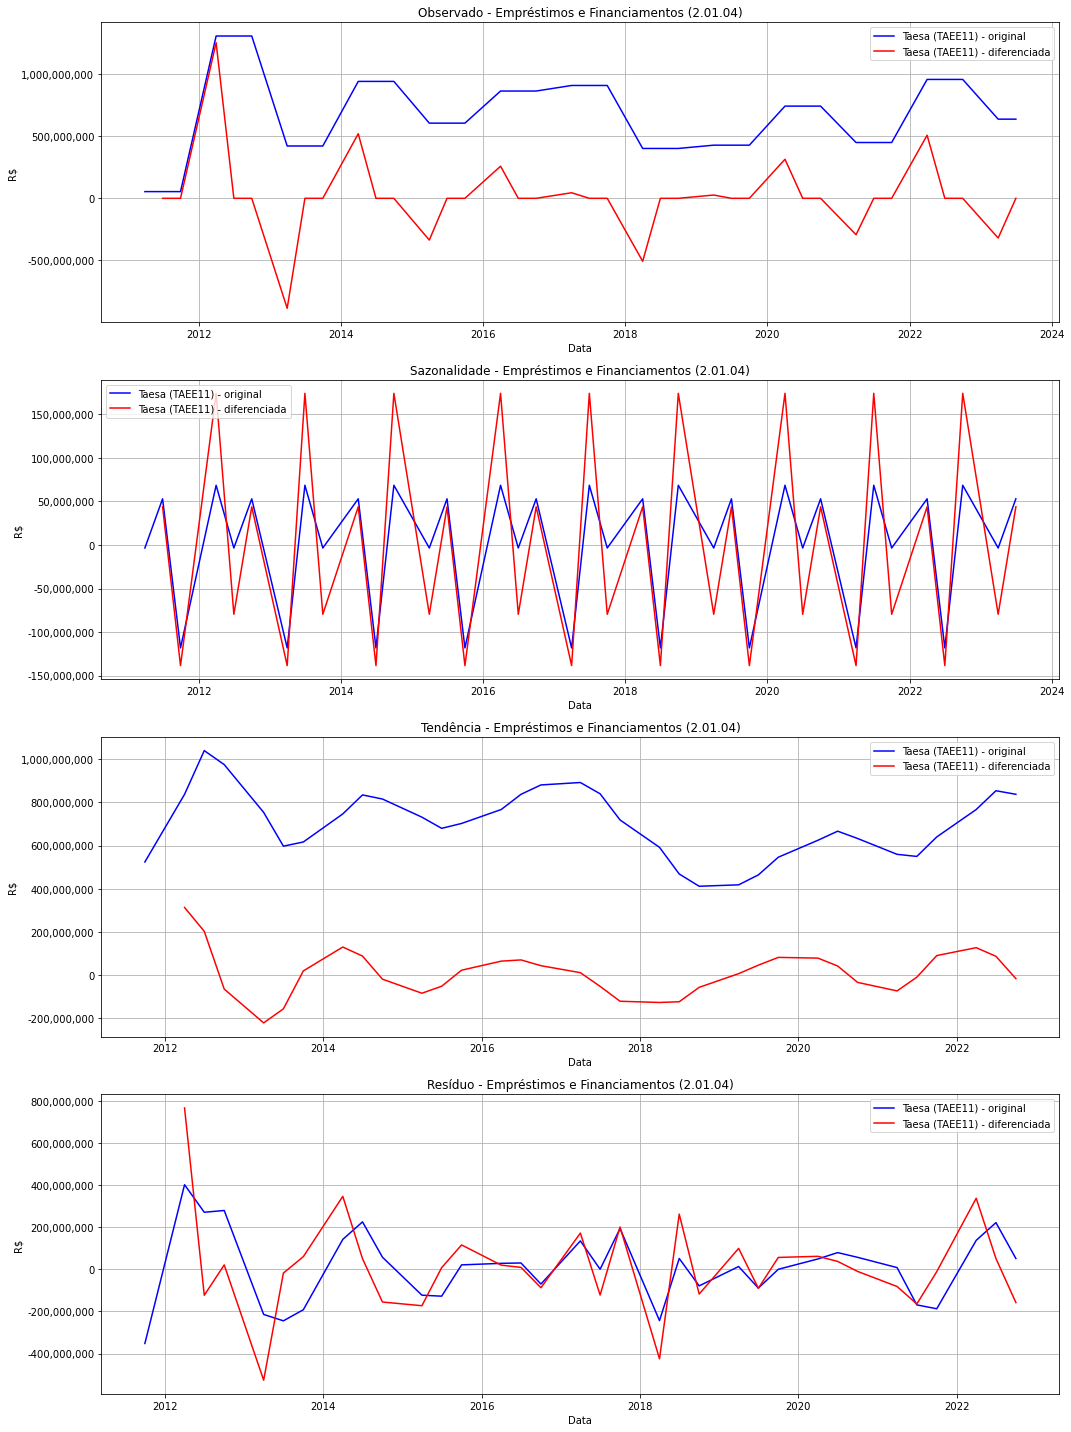


Checking if Empréstimos e Financiamentos is stationary
ADF Statistic: -12.563326179285198
ADF p-value: 2.0793941619627422e-23
Conclusion: The time series is stationary

account
{'code': '2.01.04', 'name': 'Empréstimos e Financiamentos', 'stationary': True, 'diff_count': 1}




------------------------------------------------------------------

 before differentiation
{'code': '2.02.01', 'name': 'Empréstimos e Financiamentos', 'stationary': False, 'diff_count': 0}

 after differentiation
{'code': '2.02.01', 'name': 'Empréstimos e Financiamentos', 'stationary': False, 'diff_count': 2}


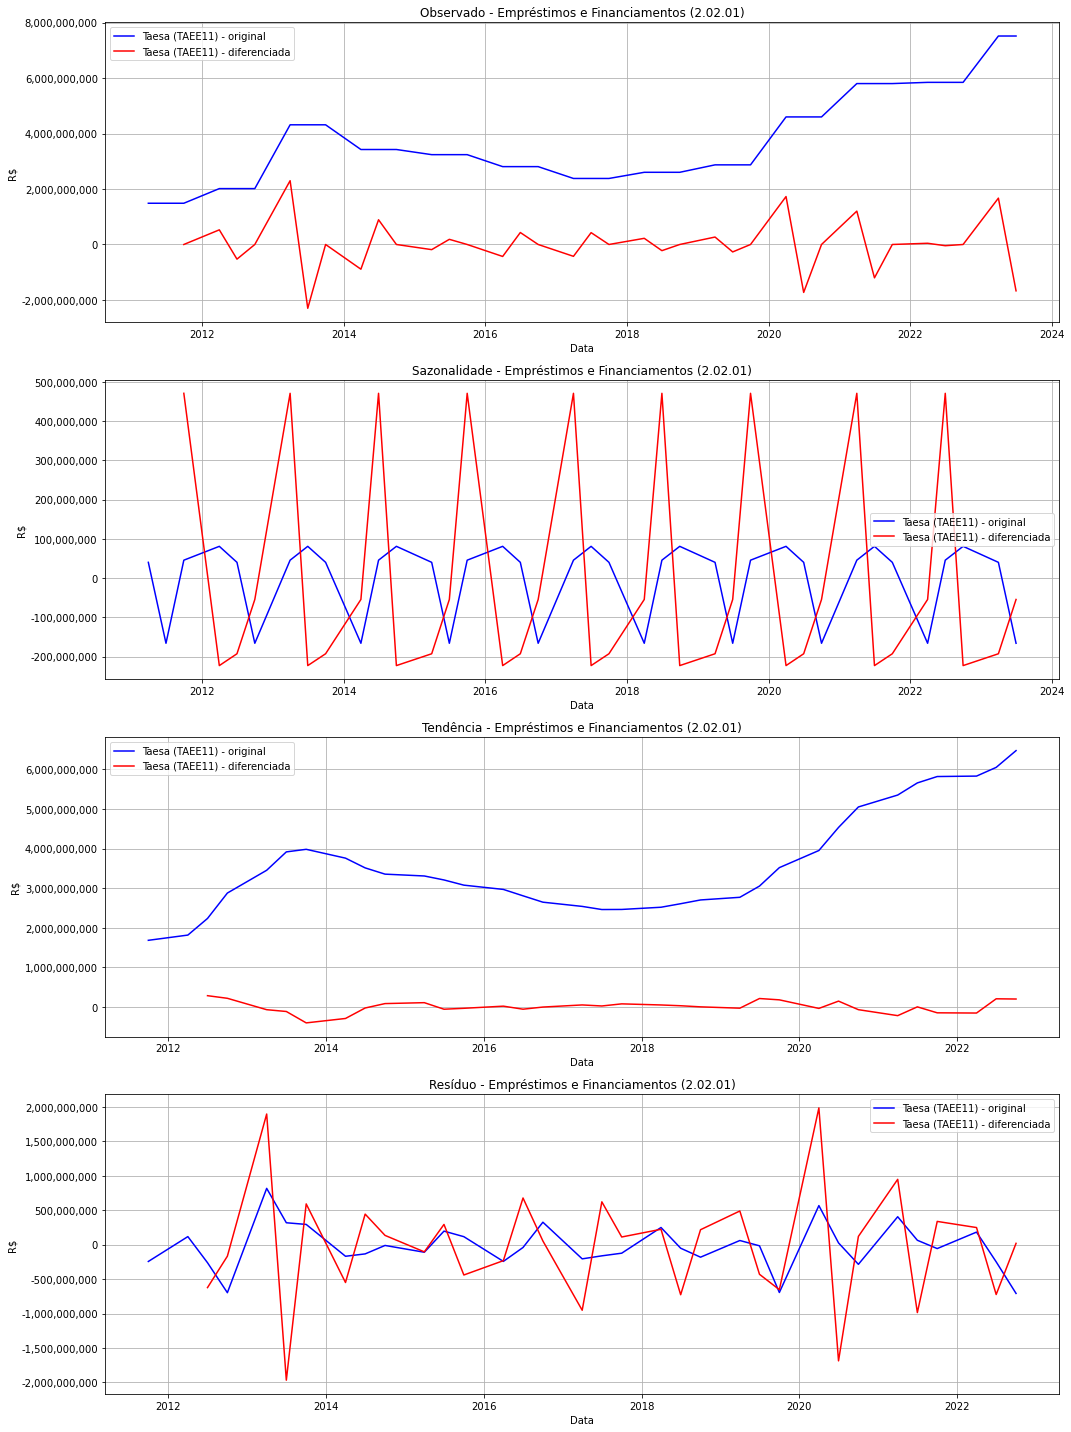


Checking if Empréstimos e Financiamentos is stationary
ADF Statistic: -7.893564124362253
ADF p-value: 4.371035949302351e-12
Conclusion: The time series is stationary

account
{'code': '2.02.01', 'name': 'Empréstimos e Financiamentos', 'stationary': True, 'diff_count': 2}




KeyError: "None of ['DT_REFER'] are in the columns"

In [36]:
import pandas as pd
import re
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


# thousand separator
formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
P_VALUE = 0.05


def adfuller_test(series):
    result = adfuller(series)
    return result[1] <= P_VALUE

def make_series_stationary(series, account, max_diff=5):
    stationary_series = series.copy()
    for _ in range(max_diff):
        stationary_series = stationary_series.diff().dropna()
        # increment differentiations
        account['diff_count'] += 1
        if adfuller_test(stationary_series):
            return stationary_series
    return None

def print_graph(size, index, data_original, data, company, title, account):
    plt.subplot(size, 1, index)
    plt.plot(data_original, label=f"{company['name']} ({company['ticker']}) - original", color='blue')
    plt.plot(data, label=f"{company['name']} ({company['ticker']}) - diferenciada", color='red')
    plt.title(f"{title} - {account['name']} ({account['code']})")
    plt.xlabel('Data')
    plt.ylabel('R$')
    plt.legend(loc='best')
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.grid(True)

def make_series_stationary_and_print(df_original, df, accounts):

    for company_code in companies:
        company = companies[company_code]

        company_data_original = df_original[df_original['CD_CVM'] == company_code]
        company_data = df[df['CD_CVM'] == company_code]

        for account_key in accounts:
            account = accounts[account_key]

            if (not account['stationary']):
                print("\n")
                print("------------------------------------------------------------------")
                account_data_original = company_data_original[account_key]
                account_data = company_data[account_key]

                # Making the series stationary
                print('\n before differentiation')
                print(account)
                account_data = make_series_stationary(account_data, account)
                print('\n after differentiation')
                print(account)

                decomposition_original = seasonal_decompose(account_data_original, model='additive', period=4)
                decomposition = seasonal_decompose(account_data, model='additive', period=4)

                plt.figure(figsize=(15, 20))

                print_graph(4, 1, decomposition_original.observed, decomposition.observed, company, 'Observado', account)
                print_graph(4, 2, decomposition_original.seasonal, decomposition.seasonal, company, 'Sazonalidade', account)
                print_graph(4, 3, decomposition_original.trend, decomposition.trend, company, 'Tendência', account)
                print_graph(4, 4, decomposition_original.resid, decomposition.resid, company, 'Resíduo', account)

                plt.tight_layout()
                plt.grid(True)
                plt.show()

                account['stationary'] = check_stationarity(account_data, account['name'])
                company_data[account_key] = account_data

                print('\naccount')
                print(account)
        
        df[df['CD_CVM'] == company_code] = company_data

    return df

df_stationary = df_pivot.copy()
df_stationary = make_series_stationary_and_print(df_pivot, df_stationary, accounts_to_calculate_fcfe)

print(df_stationary)

saveToFile('stationary', df_stationary, directory='.')


### 5.2 Modeling


#### 5.2.1 ARIMA

In [ ]:
# # ARIMA
# import numpy as np
# import pandas as pd
# import pmdarima as pm
# import matplotlib.pyplot as plt
# from pandas.tseries.offsets import DateOffset

# def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# group_of_months = 4
# frequency = 'D' 

# df_pivot = pd.read_csv('./df_fcfe.csv', sep=';', parse_dates=True, index_col='DT_REFER').asfreq('D').interpolate(method='linear')

# for company_code in companies:
#     company = companies[company_code]
#     company_data = df_pivot[df_pivot['CD_CVM'] == company_code]
    
#     # Split data
#     split_ratio = 0.9
#     train_size = int(len(company_data) * split_ratio)
#     train = company_data['FCFE'].iloc[:train_size]
#     test = company_data['FCFE'].iloc[train_size:]

#     model = pm.auto_arima(train,
#                           seasonal=True, m=group_of_months,
#                           d=0, D=1, start_P=1, start_Q=1, max_P=3, max_Q=3,
#                           trace=True, error_action='ignore', suppress_warnings=True)

#     end_date = pd.to_datetime('2024-12-31')
#     n_forecast_test = len(test)
#     n_forecast_future = (end_date - train.index[-1]).days + 1
#     n_forecast_total = n_forecast_test + n_forecast_future

#     forecast_index = pd.date_range(start=train.index[-1] + DateOffset(days=1), periods=n_forecast_total, freq=frequency)
#     predicted = model.predict(n_periods=n_forecast_total)
#     predicted_series = pd.Series(predicted, index=forecast_index)

#     if predicted_series.isnull().any():
#         print("Tentando um modelo mais simples...")
#         model = pm.ARIMA(order=(1, 0, 1))
#         model.fit(train)
#         predicted = model.predict(n_periods=n_forecast_total)
#         predicted_series = pd.Series(predicted, index=forecast_index)

#     mape = mean_absolute_percentage_error(test, predicted[:n_forecast_test])
#     accuracy = 100 - mape
#     print(f"\nMAPE: {mape:.2f}%")
#     print(f"Accuracy: {accuracy:.2f}%\n")

#     plt.figure(figsize=(15, 5))
#     plt.plot(company_data.index, company_data['FCFE'], label=f"FCFE Histórico")
#     plt.plot(predicted_series.index, predicted_series, color='red', label='FCFE Predição')
#     plt.ylim(min(min(company_data['FCFE']), min(predicted_series)), max(max(company_data['FCFE']), max(predicted_series)))
#     plt.title(f"FCFE: Histórico vs Predição - {company['name']} ({company['ticker']}) - Acurácia: {accuracy:.2f}%")
#     plt.xlabel('Data')
#     plt.ylabel('Fluxo de Caixa Livre')
#     plt.legend(loc='best')
#     plt.ticklabel_format(style='plain', axis='y')
#     ax = plt.gca()
#     ax.yaxis.set_major_formatter(formatter)
#     plt.grid(True)
#     plt.show()


Performing stepwise search to minimize aic


KeyboardInterrupt: 

#### 5.2.2 ARIMA - with exogenous variables (multivariable)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[4] intercept   : AIC=1331.336, Time=21.84 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=1342.724, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=1333.942, Time=2.25 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=1328.448, Time=3.78 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=1340.974, Time=0.06 sec
 ARIMA(0,0,1)(0,1,0)[4] intercept   : AIC=1334.860, Time=2.94 sec
 ARIMA(0,0,1)(1,1,1)[4] intercept   : AIC=1330.375, Time=3.68 sec
 ARIMA(0,0,1)(0,1,2)[4] intercept   : AIC=1330.423, Time=3.23 sec
 ARIMA(0,0,1)(1,1,0)[4] intercept   : AIC=1330.145, Time=2.66 sec
 ARIMA(0,0,1)(1,1,2)[4] intercept   : AIC=1332.031, Time=9.17 sec
 ARIMA(0,0,0)(0,1,1)[4] intercept   : AIC=1334.848, Time=1.33 sec
 ARIMA(1,0,1)(0,1,1)[4] intercept   : AIC=1330.118, Time=6.17 sec
 ARIMA(0,0,2)(0,1,1)[4] intercept   : AIC=1328.834, Time=3.71 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=1331.921, Time=1.63 sec
 ARIMA(1,0,2)(0,1,1)[4] intercep

/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  sel


MAPE: 83.84%
Accuracy: 16.16%



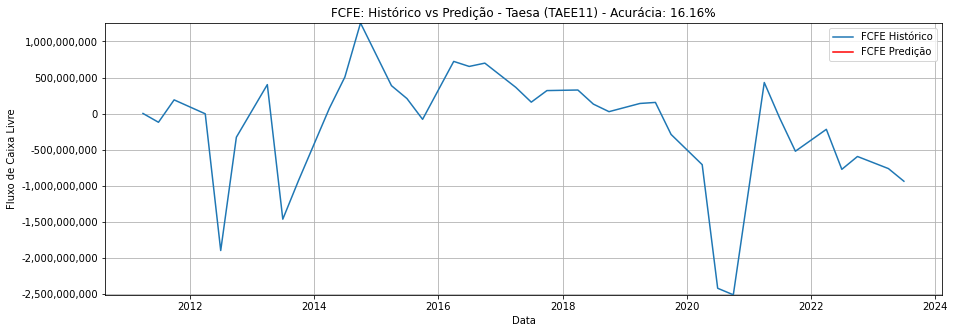

In [ ]:
# # ARIMA - with exogenous variables (multivariable)
# import numpy as np
# import pandas as pd
# import pmdarima as pm
# import matplotlib.pyplot as plt
# from pandas.tseries.offsets import DateOffset

# def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# # def remove_low_correlation_columns(df, threshold=0.5):
# #     correlations = df.corrwith(df['FCFE'])
# #     low_corr_columns = correlations[correlations.abs() < threshold].index.tolist()
# #     return df.drop(columns=low_corr_columns)

# group_of_months = 4
# months = 3
# frequency = 'D' 

# # Read the data
# df_pivot = pd.read_csv('./df_fcfe.csv', sep=';', parse_dates=True, index_col='DT_REFER')

# for company_code in companies:
#     company = companies[company_code]
#     company_data = df_pivot[df_pivot['CD_CVM'] == company_code]
    
#     # Remove columns with low correlation
#     # company_data = remove_low_correlation_columns(company_data)
    
#     # Split data
#     split_ratio = 0.9
#     train_size = int(len(company_data) * split_ratio)
#     train = company_data.iloc[:train_size]
#     test = company_data.iloc[train_size:]
#     exog_train = train.drop(columns=['FCFE', 'CD_CVM'])

#     assert not exog_train.isnull().any().any(), "Existem NaNs em exog_train"

#     model = pm.auto_arima(train['FCFE'],
#                           exogenous=exog_train,
#                           seasonal=True, m=group_of_months,
#                           d=0, D=1, start_P=1, start_Q=1, max_P=3, max_Q=3,
#                           trace=True, error_action='ignore', suppress_warnings=True)

#     end_date = pd.to_datetime('2024-12-31')
#     n_forecast_test = len(test)
#     n_forecast_future = (end_date - train.index[-1]).days + 1
#     n_forecast_total = n_forecast_test + n_forecast_future
    
#     forecast_index = pd.date_range(start=train.index[-1] + DateOffset(days=1), periods=n_forecast_total, freq=frequency)
#     exog_forecast = pd.DataFrame([exog_train.iloc[-1]] * n_forecast_total, columns=exog_train.columns, index=forecast_index)

#     predicted = model.predict(n_periods=n_forecast_total, exogenous=exog_forecast)
#     predicted_series = pd.Series(predicted, index=forecast_index)

#     if predicted_series.isnull().any():
#         print("Tentando um modelo mais simples...")
#         model = pm.ARIMA(order=(1, 0, 1))
#         model.fit(train['FCFE'], exogenous=exog_train)
#         predicted = model.predict(n_periods=n_forecast_total, exogenous=exog_forecast)
#         predicted_series = pd.Series(predicted, index=forecast_index)

#     mape = mean_absolute_percentage_error(test['FCFE'], predicted[:n_forecast_test])
#     accuracy = 100 - mape
#     print(f"\nMAPE: {mape:.2f}%")
#     print(f"Accuracy: {accuracy:.2f}%\n")

#     plt.figure(figsize=(15, 5))
#     plt.plot(company_data.index, company_data['FCFE'], label=f"FCFE Histórico")
#     plt.plot(predicted_series.index, predicted_series, color='red', label='FCFE Predição')
#     plt.ylim(min(min(company_data['FCFE']), min(predicted_series)), max(max(company_data['FCFE']), max(predicted_series)))
#     plt.title(f"FCFE: Histórico vs Predição - {company['name']} ({company['ticker']}) - Acurácia: {accuracy:.2f}%")
#     plt.xlabel('Data')
#     plt.ylabel('Fluxo de Caixa Livre')
#     plt.legend(loc='best')
#     plt.ticklabel_format(style='plain', axis='y')
#     ax = plt.gca()
#     ax.yaxis.set_major_formatter(formatter)
#     plt.grid(True)
#     plt.show()


#### 5.2.3 GLM

/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  VL_CONTA_7.02                  with p-value 6.92099e-07


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO with p-value 0.00147928


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  VL_CONTA_PENULTIMO_3.02        with p-value 6.77744e-05


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  VL_CONTA_PENULTIMO_6.03        with p-value 0.000856722


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES with p-value 0.000761143


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  VL_CONTA_1.01.01               with p-value 0.00183483


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  VL_CONTA_1.01.03               with p-value 0.00475669
Drop CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO with p-value 0.633221


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  VL_CONTA_PENULTIMO_3.05        with p-value 7.43138e-05


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  DELTA_ATIVO_CIRCULANTE         with p-value 0.00433184
Drop VL_CONTA_PENULTIMO_6.03        with p-value 0.279459


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES with p-value 5.97931e-10


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  VL_CONTA_6.05                  with p-value 2.78387e-08
Drop VL_CONTA_1.01.03               with p-value 0.213238


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  LUCRO_LIQUIDO_PERIODO          with p-value 1.74365e-26
Drop VL_CONTA_PENULTIMO_3.05        with p-value 0.246646


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  DELTA_PASSIVO_CIRCULANTE       with p-value 9.0171e-282
Drop VL_CONTA_PENULTIMO_3.02        with p-value 0.551751


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  VL_CONTA_3.09                  with p-value 0.0
Drop VL_CONTA_7.02                  with p-value 0.777285


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  DELTA_IMOBILIZADO              with p-value 4.54626e-68
Drop VL_CONTA_1.01.01               with p-value 0.372056


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA with p-value 0.0


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  VL_CONTA_7.04.01               with p-value 0.0


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  VL_CONTA_3.11                  with p-value 0.0


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  DELTA_CAIXA_E_EQUIVALENTES_DE_CAIXA with p-value 0.0


/tmp/ipykernel_907955/1486510555.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


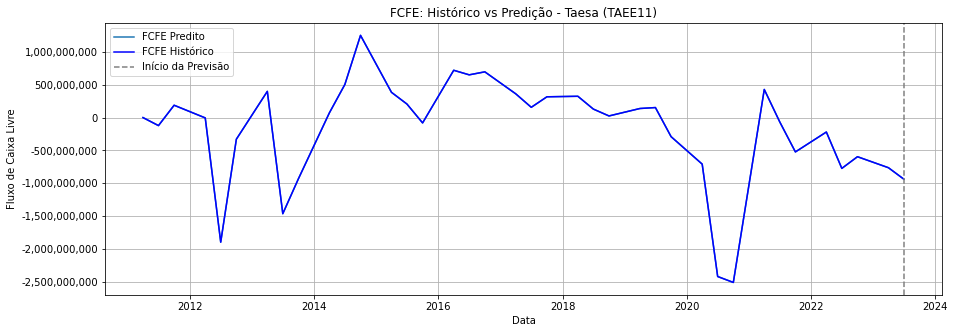

In [ ]:
# # GLM
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import statsmodels.api as sm
# from pandas.tseries.offsets import DateOffset

# def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# def stepwise_selection(X, y, 
#                        initial_list=[], 
#                        threshold_in=0.01, 
#                        threshold_out = 0.05, 
#                        verbose=True):
#     included = list(initial_list)
#     while True:
#         changed=False
#         # forward step
#         excluded = list(set(X.columns)-set(included))
#         new_pval = pd.Series(index=excluded)
#         for new_column in excluded:
#             model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
#             new_pval[new_column] = model.pvalues[new_column]
#         best_pval = new_pval.min()
#         if best_pval < threshold_in:
#             best_feature = new_pval.idxmin()
#             included.append(best_feature)
#             changed=True
#             if verbose:
#                 print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

#         # backward step
#         model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
#         pvalues = model.pvalues.iloc[1:]
#         worst_pval = pvalues.max() 
#         if worst_pval > threshold_out:
#             changed=True
#             worst_feature = pvalues.idxmax()
#             included.remove(worst_feature)
#             if verbose:
#                 print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
#         if not changed:
#             break
#     return included

# # Read the data
# df_pivot = pd.read_csv('./df_fcfe.csv', sep=';', parse_dates=True, index_col='DT_REFER')

# for company_code in companies:
#     company = companies[company_code]
#     company_data = df_pivot[df_pivot['CD_CVM'] == company_code]
    
#     # Train the model on all available data up to the current date for better predictions
#     X = company_data.drop(columns=['FCFE', 'CD_CVM'])
#     y = company_data['FCFE']
    
#     features = stepwise_selection(X, y)

#     X = sm.add_constant(company_data[features])
#     model = sm.GLM(y, X).fit()

#     # Predict on existing data
#     predicted_existing = model.predict(X)

#     # Create future data
#     last_date = company_data.index[-1]
#     future_dates = pd.date_range(last_date + DateOffset(days=1), '2024-12-31')
#     future_data = pd.DataFrame(index=future_dates)
#     future_data = future_data.join(df_pivot, how='left')  # Join to get the structure
#     future_data['CD_CVM'] = company_code
#     future_data[features] = np.nan  # No data for future, but you might have some other indicators/features
    
#     X_future = sm.add_constant(future_data[features])
#     predicted_future = model.predict(X_future)

#     # Combine historical and predicted for plotting
#     all_dates = company_data.index.append(future_dates)
#     all_values = np.concatenate([company_data['FCFE'].values, predicted_future.values])

#     # Plot
#     plt.figure(figsize=(15, 5))
#     plt.plot(all_dates, all_values, label='FCFE Predito')
#     plt.plot(company_data.index, company_data['FCFE'], label='FCFE Histórico', color='blue')
#     plt.axvline(x=last_date, color='grey', linestyle='--', label='Início da Previsão')
#     plt.title(f"FCFE: Histórico vs Predição - {company['name']} ({company['ticker']})")
#     plt.xlabel('Data')
#     plt.ylabel('Fluxo de Caixa Livre')
#     plt.legend(loc='best')
#     plt.ticklabel_format(style='plain', axis='y')
#     ax = plt.gca()
#     ax.yaxis.set_major_formatter(formatter)
#     plt.grid(True)
#     plt.show()


### 5.3 Free Cash Flow formula

*FCFE = <br>
  3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE)<br>
  \- (Δ 1.02.03 (Imobilizado) - 7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA))<br>
  \- (Δ 1.01 (Ativo Circulante) - Δ 1.01.01 (Caixa e Equivalentes de Caixa) -  Δ 2.01 (Passivo Circulante))<br>
  \+ (Δ 2.01.04(Emprestimos e Financiamentos Circulantes) + Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes))*<br><br>


*3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE) = <br>
  LUCRO_LIQUIDO_PERIODO*<br>


*Δ 1.02.03 (Imobilizado) = <br>
  IMOBILIZADO_NO_PERIODO_ANTERIOR - IMOBILIZADO_NO_PERIODO*<br>


*7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA) = <br>
  DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA*<br>


*Δ 1.01 (Ativo Circulante) = <br>
  ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR - ATIVO_CIRCULANTE_NO_PERIODO*<br>


*Δ 1.01.01 (Caixa e Equivalentes de Caixa) = <br>
  CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR - CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO*<br>


*Δ 2.01 (Passivo Circulante) = <br>
  PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR - PASSIVO_CIRCULANTE_NO_PERIODO*<br>


*Δ 2.01.04(Emprestimos e Financiamentos Circulantes) = <br>
  EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR - EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO*<br>


*Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes) = <br>
  EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR - EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO*<br>

#### 5.3.1 Calculate FCFE value

In [ ]:
####################################################################
# Lucro/Prejuizo Consolidado do Periodo do DRE (3.11)
####################################################################
df_pivot['LUCRO_LIQUIDO_PERIODO'] = df_pivot['VL_CONTA_3.11']


####################################################################
# Δ Imobilizado (1.02.03)
####################################################################
df_pivot['IMOBILIZADO_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_1.02.03']
df_pivot['IMOBILIZADO_NO_PERIODO'] = df_pivot['VL_CONTA_1.02.03']
df_pivot['DELTA_IMOBILIZADO'] = df_pivot['IMOBILIZADO_NO_PERIODO_ANTERIOR'] - df_pivot['IMOBILIZADO_NO_PERIODO']


####################################################################
# Depreciacao, Amortizacao e Exaustao da DVA (7.04.01)
####################################################################
df_pivot['DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA'] = df_pivot['VL_CONTA_7.04.01']


####################################################################
# Δ Ativo Circulante (1.01)
####################################################################
df_pivot['ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_1.01']
df_pivot['ATIVO_CIRCULANTE_NO_PERIODO'] = df_pivot['VL_CONTA_1.01']
df_pivot['DELTA_ATIVO_CIRCULANTE'] = df_pivot['ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] - df_pivot['ATIVO_CIRCULANTE_NO_PERIODO']


####################################################################
# Δ Caixa e Equivalentes de Caixa (1.01.01)
####################################################################
df_pivot['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_1.01.01']
df_pivot['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO'] = df_pivot['VL_CONTA_1.01.01']
df_pivot['DELTA_CAIXA_E_EQUIVALENTES_DE_CAIXA'] = df_pivot['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR'] - df_pivot['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO']


####################################################################
# Δ Passivo Circulante (2.01)
####################################################################
df_pivot['PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_2.01']
df_pivot['PASSIVO_CIRCULANTE_NO_PERIODO'] = df_pivot['VL_CONTA_2.01']
df_pivot['DELTA_PASSIVO_CIRCULANTE'] = df_pivot['PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] - df_pivot['PASSIVO_CIRCULANTE_NO_PERIODO']


####################################################################
# Δ Emprestimos e Financiamentos Circulantes (2.01.04)
####################################################################
df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_2.01.04']
df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO'] = df_pivot['VL_CONTA_2.01.04']
df_pivot['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES'] = df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR'] - df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO']


####################################################################
# Δ Emprestimos e Financiamentos Nao Circulantes (2.02.01)
####################################################################
df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR'] = df_pivot['VL_CONTA_PENULTIMO_2.02.01']
df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO'] = df_pivot['VL_CONTA_2.02.01']
df_pivot['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES'] = df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR'] - df_pivot['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO']


# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#
# Fluxo de Caixa Livre para os Acionistas (Free Cash Flows to Equity) - FCFE
#
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
df_pivot['FCFE'] = \
    df_pivot['LUCRO_LIQUIDO_PERIODO'] \
    - ( df_pivot['DELTA_IMOBILIZADO'] - df_pivot['DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA'] ) \
    - ( df_pivot['DELTA_ATIVO_CIRCULANTE'] - df_pivot['DELTA_CAIXA_E_EQUIVALENTES_DE_CAIXA'] - df_pivot['DELTA_PASSIVO_CIRCULANTE'] ) \
    + ( df_pivot['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES'] + df_pivot['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES'])

df_pivot.head()


CD_CVM  VL_CONTA_1.01  VL_CONTA_1.01.01  VL_CONTA_1.01.03  \
DT_REFER                                                                
2011-03-31   20257   1.304282e+09      6.404360e+08      6.352210e+08   
2011-06-30   20257   1.015506e+09      3.560120e+08      6.394430e+08   
2011-09-30   20257   1.200952e+09      4.737780e+08      7.111610e+08   
2012-03-31   20257   1.754579e+09      6.910900e+08      1.004641e+09   
2012-06-30   20257   2.578940e+09      1.529686e+09      1.011221e+09   

            VL_CONTA_1.02.01  VL_CONTA_1.02.03  VL_CONTA_1.02.04  \
DT_REFER                                                           
2011-03-31      3.351158e+09        12438000.0         4090000.0   
2011-06-30      3.294360e+09        12622000.0         4022000.0   
2011-09-30      3.487406e+09        12949000.0         3953000.0   
2012-03-31      4.832303e+09        14292000.0         6369000.0   
2012-06-30      4.503117e+09        14825000.0         6270000.0   

            VL_CONTA_2.01  VL_CONTA_2.01.02  VL_CONTA_2.01.03  ...  \
DT_REFER                                                       ...   
2011-03-31   3.347010e+08         8245000.0         7513000.0  ...   
2011-06-30   4.577490e+08         5017000.0         4680000.0  ...   
2011-09-30   4.423480e+08         7542000.0         5302000.0  ...   
2012-03-31   1.703948e+09        14772000.0        19873000.0  ...   
2012-06-30   2.627695e+09        12867000.0        17509000.0  ...   

            PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR  \
DT_REFER                                             
2011-03-31                            3.082160e+08   
2011-06-30                            3.082160e+08   
2011-09-30                            3.084950e+08   
2012-03-31                            1.647891e+09   
2012-06-30                            1.647891e+09   

            PASSIVO_CIRCULANTE_NO_PERIODO  DELTA_PASSIVO_CIRCULANTE  \
DT_REFER                                                              
2011-03-31                   3.347010e+08               -26485000.0   
2011-06-30                   4.577490e+08              -149533000.0   
2011-09-30                   4.423480e+08              -133853000.0   
2012-03-31                   1.703948e+09               -56057000.0   
2012-06-30                   2.627695e+09              -979804000.0   

            EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR  \
DT_REFER                                                                   
2011-03-31                                       5.401700e+07              
2011-06-30                                       5.401700e+07              
2011-09-30                                       5.401700e+07              
2012-03-31                                       1.307947e+09              
2012-06-30                                       1.307947e+09              

            EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO  \
DT_REFER                                                          
2011-03-31                                       9.476200e+07     
2011-06-30                                       8.867300e+07     
2011-09-30                                       6.866900e+07     
2012-03-31                                       1.378329e+09     
2012-06-30                                       2.310695e+09     

            DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES  \
DT_REFER                                                     
2011-03-31                                   -4.074500e+07   
2011-06-30                                   -3.465600e+07   
2011-09-30                                   -1.465200e+07   
2012-03-31                                   -7.038200e+07   
2012-06-30                                   -1.002748e+09   

            EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR  \
DT_REFER                                                                       
2011-03-31                                       1.487279

#### 5.3.2 Saving result

In [ ]:
saveToFile('fcfe', df_pivot)


NameError: name 'saveToFile' is not defined

#### 5.3.3 Loading result

In [ ]:
# def reorder(df, column, position):
#     cols = list(df.columns)
#     cols.remove(column)
#     cols.insert(position, column)
#     df = df[cols]
#     return df

# print_df = reorder(df_pivot, 'DT_REFER', 0)
# print_df = reorder(print_df, 'CD_CVM', 1)
# print_df = reorder(print_df, 'FCFE', 2)
# print_df = reorder(print_df, 'LUCRO_LIQUIDO_PERIODO', 3)
# print_df = reorder(print_df, 'DELTA_IMOBILIZADO', 4)
# print_df = reorder(print_df, 'DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA', 5)
# print_df = reorder(print_df, 'DELTA_ATIVO_CIRCULANTE', 6)
# print_df = reorder(print_df, 'DELTA_CAIXA_E_EQUIVALENTES_DE_CAIXA', 7)
# print_df = reorder(print_df, 'DELTA_PASSIVO_CIRCULANTE', 8)
# print_df = reorder(print_df, 'DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES', 9)
# print_df = reorder(print_df, 'DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES', 10)

# print_df.head()

# df_pivot = df_pivot.set_index('DT_REFER')


#df_pivot = pd.read_csv('./df_fcfe.csv', sep=';', parse_dates=True, index_col='DT_REFER').asfreq('D').interpolate(method='linear')
df_pivot = pd.read_csv('./df_fcfe.csv', sep=';', parse_dates=True, index_col='DT_REFER')

print("\n")
print(df_pivot.info())
print("\n")
print(df_pivot.head(100))


## 5 Exploratory Data Analysis (EDA)

### 5.1 Loading the data already strutured and cleaned

In [ ]:
import pandas as pd

data = pd.read_csv('df_fcfe.csv', sep=';')

data['DT_REFER'] = pd.to_datetime(data['DT_REFER'], format='%Y-%m-%d')
data = data.set_index('DT_REFER')


### 5.7 Predictions

#### 5.7.1 Prediction using ARIMA

**ARIMA (Autoregressive Integrated Moving Average)**

It is a widely-used approach for time series forecasting. The model relies on three main components:

- **Autoregression (AR):** Refers to the relationship between an observation and a number of lagged observations.
- **Integrated (I):** Refers to the use of differencing to make the time series stationary.
- **Moving Average (MA):** Uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

**Source:**
- Box, G. E., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2015). *Time series analysis: forecasting and control*. John Wiley & Sons.

#### 5.7.2 Prediction using SARIMA

**SARIMA (Seasonal Autoregressive Integrated Moving Average)**

SARIMA adds an additional seasonal component to the ARIMA model, making it suitable for time series with clear seasonal patterns. The components of SARIMA are:

- **Seasonal Autoregression (SAR):** Refers to the relationship between an observation and a number of seasonally lagged observations.
- **Seasonal Integrated (SI):** Uses seasonal differencing to make the series stationary.
- **Seasonal Moving Average (SMA):** Uses the dependency between an observation and a residual error from a moving average model applied to seasonally lagged observations.

**Source:**
- Hyndman, R. J., & Athanasopoulos, G. (2018). *Forecasting: principles and practice*. OTexts.


#### 5.7.3 Prediction using XGBoost

**XGBoost (Extreme Gradient Boosting)**

XGBoost, short for "Extreme Gradient Boosting", is a decision-tree-based ensemble Machine Learning algorithm. It uses a gradient boosting framework. XGBoost is especially known for its speed and performance. For time series forecasting, it works best when combined with time-based features and lagged values of the series to be predicted.

- **Tree-based Modeling:** At its core, XGBoost constructs decision trees like other boosting algorithms, such as Gradient Boosting Machines (GBM).
- **Regularization:** XGBoost includes L1 (Lasso Regression) and L2 (Ridge Regression) regularization which prevents the model from overfitting.
- **Parallel Processing:** It's known for its performance; it's parallel and distributed computing makes it incredibly fast.

**Source:**
- Chen, T., & Guestrin, C. (2016, August). *Xgboost: A scalable tree boosting system*. In Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining (pp. 785-794).

#### 5.7.4 Prediction using LSTM

**LSTM (Long Short-Term Memory)**

LSTM is a special kind of Recurrent Neural Network (RNN) architecture optimized for sequences and time series data. Unlike traditional RNNs which struggle to learn and retain long-term dependencies due to issues like vanishing gradient, LSTMs are explicitly designed to avoid long-term dependency issues. The key features of LSTM are:

- **Memory Cell:** At its core, LSTM has a cell state, often referred to as the "memory cell", which can maintain its state over time, acting somewhat like a conveyor belt. It allows information to be passed down unchanged if needed.

- **Gates:** LSTMs have three gates to control the cell state and output:
  1. **Forget Gate:** Decides what information should be discarded or kept.
  2. **Input Gate:** Updates the cell state with new information.
  3. **Output Gate:** Determines the output based on the cell state and the input.

By virtue of these gates and the memory cell, LSTMs can model and predict patterns in time series and sequences over long periods effectively, making them popular for many sequence prediction problems.

**Sources:**
- Hochreiter, S., & Schmidhuber, J. (1997). *Long short-term memory*. Neural computation, 9(8), 1735-1780.
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press. [Online version available](http://www.deeplearningbook.org/)


##### 5.7.4.1 Data

In [ ]:
print(df_original.info())
print(df_original.head())

print(stationary_series_dict)

##### 5.7.4.2 Algorithms

In [ ]:
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# import xgboost as xgb
# from statsmodels.genmod.generalized_linear_model import GLM
# from statsmodels.genmod.families import Gaussian


# def generate_lags_multivariate(df, n_lags, target_column='FCFE'):
#     """
#     Generate lag features for multivariate time series data.
#     """
#     lag_data = []
#     for i in range(n_lags, 0, -1):
#         df_shifted = df.shift(i)
#         df_shifted.columns = [f"{col}_lag{i}" for col in df.columns]
#         lag_data.append(df_shifted)
    
#     df_lagged = pd.concat(lag_data, axis=1)
#     df_lagged = df_lagged.dropna()
    
#     X = df_lagged.drop(columns=[f"{target_column}_lag{i}" for i in range(1, n_lags+1)])
#     y = df_lagged[f"{target_column}_lag1"]
    
#     return X.values, y.values


# def arima_forecast(train_series, steps):
#     print('\n------------------------------------------------------------------')
#     print(f'[ arima_forecast ]')
#     model = ARIMA(train_series, order=(1,1,1))
#     fit_model = model.fit()
#     predictions = fit_model.forecast(steps=steps)
#     return predictions

# def sarima_forecast(train_series, steps):
#     print('\n------------------------------------------------------------------')
#     print(f'[ sarima_forecast ]')
#     model = SARIMAX(train_series, order=(1,1,1), seasonal_order=(1,1,1,4))
#     fit_model = model.fit()
#     predictions = fit_model.forecast(steps=steps)
#     return predictions

# def xgboost_forecast(train, steps):
#     print('\n------------------------------------------------------------------')
#     print(f'[ xgboost_forecast ]')
#     X, y = generate_lags_multivariate(train, n_lags)
    
#     model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
#     model.fit(X, y)

#     forecasts = []
#     recent_data = list(train[-n_lags:])
#     for _ in range(steps):
#         X_new = np.array([recent_data[-n_lags:]])
#         forecast = model.predict(X_new)
#         forecasts.append(forecast[0])
#         recent_data.append(forecast[0])

#     return np.array(forecasts)

# def glm_forecast(train, steps):
#     print('\n------------------------------------------------------------------')
#     print(f'[ glm_forecast ]')
#     X, y = generate_lags_multivariate(train, n_lags)
    
#     glm = GLM(y, X, family=Gaussian())
#     model = glm.fit()

#     forecasts = []
#     recent_data = list(train[-n_lags:])
#     for _ in range(steps):
#         X_new = np.array([recent_data[-n_lags:]])
#         forecast = model.predict(X_new)
#         forecasts.append(forecast[0])
#         recent_data.append(forecast[0])

#     return np.array(forecasts)


##### 5.7.4.3 Error Functions

In [ ]:
# from sklearn.metrics import mean_squared_error

# def calculate_rmse(true_values, predicted_values):
#     return np.sqrt(mean_squared_error(true_values, predicted_values))

# # Função para calcular o MAPE
# def calculate_mape(true_values, predicted_values):
#     return np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

##### 5.7.4.4 Plotting Functions

In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd

# def plot_ensemble_forecasts(train_series, test_series, arima_preds, preds_sarima, preds_xgboost, preds_glm, preds_ensemble, company_name, best_model, accuracy):
#     plt.figure(figsize=(18, 6))

#     # Limitando os dados de treinamento para os últimos 3 anos
#     three_years_ago = pd.Timestamp(train_series.index[-1] - pd.DateOffset(years=3))
#     limited_train_series = train_series[three_years_ago:]

#     plt.plot(limited_train_series.index, limited_train_series.values, label='Dados de Treinamento (Últimos 3 anos)', color='grey')

#     # Criando o índice para as previsões
#     forecast_start = train_series.index[-1] + pd.DateOffset(days=1)
#     forecast_end = forecast_start + pd.DateOffset(days=len(arima_preds)-1)
#     forecast_index = pd.date_range(forecast_start, forecast_end, freq='D')

#     # Plotando o brilho para a linha do modelo vencedor
#     glow_width = 4
#     lw_arima, lw_sarima, lw_xgboost, lw_glm, lw_ensemble = 1, 1, 1, 1, 1
#     if best_model == "ARIMA":
#         lw_arima = 3
#         plt.plot(forecast_index, arima_preds, color='red', linestyle='--', linewidth=glow_width, alpha=0.3)
#     elif best_model == "SARIMA":
#         lw_sarima = 3
#         plt.plot(forecast_index, preds_sarima, color='green', linestyle='--', linewidth=glow_width, alpha=0.3)
#     elif best_model == "XGBoost":
#         lw_xgboost = 3
#         plt.plot(forecast_index, preds_xgboost, color='cyan', linestyle='--', linewidth=glow_width, alpha=0.3)
#     elif best_model == "GLM":
#         lw_glm = 3
#         plt.plot(forecast_index, preds_glm, color='orange', linestyle='--', linewidth=glow_width, alpha=0.3)
#     else:
#         lw_ensemble = 3
#         plt.plot(forecast_index, preds_ensemble, color='black', linestyle='-', linewidth=glow_width, alpha=0.3)

#     # Plotando as linhas regulares
#     plt.plot(forecast_index, arima_preds, label='Previsões ARIMA', color='red', linestyle='--', linewidth=lw_arima)
#     plt.plot(forecast_index, preds_sarima, label='Previsões SARIMA', color='green', linestyle='--', linewidth=lw_sarima)
#     plt.plot(forecast_index, preds_xgboost, label='Previsões XGBoost', color='cyan', linestyle='--', linewidth=lw_xgboost)
#     plt.plot(forecast_index, preds_glm, label='Previsões GLM', color='orange', linestyle='--', linewidth=lw_glm)
#     plt.plot(forecast_index, preds_ensemble, label='Previsões Ensembled', color='black', linestyle='-', linewidth=lw_ensemble)
#     plt.plot(test_series.index, test_series.values, label='Dados Reais', color='blue')

#     plt.ylabel('Fluxo de Caixa Livre para os Acionistas (FCLA) em Reais')

#     plt.legend(loc='upper left')
#     plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
#     plt.title(f"Comparação para {company_name}: Dados de Treinamento, Dados Reais vs. Previsões (Melhor modelo: {best_model}) (Acurácia: {accuracy:.2f}%)")
#     plt.grid(True)
#     plt.show()

##### 5.7.4.5 Calling Algorithms

In [ ]:
# import pandas as pd

# for company_code, series in stationary_series_dict.items():
#     print(f'\ncompany_code: {company_code}')
#     company_name = companies[company_code]['name']

#     # Ajuste de frequência e interpolação para os modelos ARIMA e SARIMA
#     series_stationary = series.asfreq('D').interpolate(method='linear')
#     series_stationary = series_stationary.asfreq('D')

#     # Para XGBoost e GLM, você vai usar a série original, que está em 'df'
#     # series_original = df[df['CD_CVM'] == company_code].asfreq('D').interpolate(method='linear')
#     # series_original = series_original.asfreq('D')
#     series_original = df_original[df_original['CD_CVM'] == company_code]

#     # Aqui está a mudança: Definindo o ponto de divisão para treinamento até o final de 2022 (2022-12-31)
#     split_date = pd.to_datetime(str((year_interval_end-1)) + "-12-31")


#     # Criando séries de treinamento e teste para ARIMA e SARIMA (usando a série estacionária)
#     train_series_stationary = series_stationary.loc[:split_date]
#     test_series_stationary = series_stationary.loc[(split_date + pd.DateOffset(days=1)):]

#     # Criando séries de treinamento e teste para XGBoost e GLM (usando a série original)
#     train_series_original = series_original.loc[:split_date]
#     test_series_original = series_original.loc[(split_date + pd.DateOffset(days=1)):]


#     # Forecasts individuais
#     # (2024-12-31) - (2022-12-31) = 2 years = 2 * 365 = 730
#     forecast_steps = (pd.to_datetime(str(year_interval_end+1) + "-12-31") - split_date).days
#     print(f'\nforecast_steps: {forecast_steps}\n')


#     # Usando a série estacionária para ARIMA e SARIMA
#     preds_arima = arima_forecast(train_series_stationary.values, forecast_steps)
#     preds_sarima = sarima_forecast(train_series_stationary.values, forecast_steps)

#     # Usando a série original para XGBoost e GLM
#     #preds_xgboost = xgboost_forecast(train_series_original.values, forecast_steps)
#     #preds_glm = glm_forecast(train_series_original.values, forecast_steps)
#     preds_xgboost = xgboost_forecast(train_series_original.values, forecast_steps)
#     preds_glm = glm_forecast(train_series_original.values, forecast_steps)


#    # Ensemble forecast
#     preds_ensemble = (preds_arima + preds_sarima + preds_xgboost + preds_glm) / 4


#     # Calculando erros
#     rmse_arima = calculate_rmse(test_series_stationary.values, preds_arima[:len(test_series_stationary)])
#     print(f'ARIMA error: {rmse_arima}')
#     rmse_sarima = calculate_rmse(test_series_stationary.values, preds_sarima[:len(test_series_stationary)])
#     print(f'SARIMA error: {rmse_sarima}')
#     rmse_xgboost = calculate_rmse(test_series_original.values, preds_xgboost[:len(test_series_original)])
#     print(f'XGBoost error: {rmse_xgboost}')
#     rmse_glm = calculate_rmse(test_series_original.values, preds_glm[:len(test_series_original)])
#     print(f'GLM error: {rmse_glm}')

#     # Para o ensemble, vamos assumir que test_series_stationary é do mesmo tamanho que test_series_original
#     rmse_ensemble = calculate_rmse(test_series_original.values, preds_ensemble[:len(test_series_original)])
#     print(f'Ensemble error: {rmse_ensemble}')

#     best_rmse = min(rmse_arima, rmse_sarima, rmse_xgboost, rmse_glm, rmse_ensemble)


#     # Accuracy
#     mape_arima = calculate_mape(test_series_stationary, preds_arima[:len(test_series_stationary)])
#     mape_sarima = calculate_mape(test_series_stationary, preds_sarima[:len(test_series_stationary)])
#     mape_xgboost = calculate_mape(test_series_original, preds_xgboost[:len(test_series_original)])
#     mape_glm = calculate_mape(test_series_original, preds_glm[:len(test_series_original)])
#     mape_ensemble = calculate_mape(test_series_original, preds_ensemble[:len(test_series_original)])

#     accuracy_arima = 100 - mape_arima
#     accuracy_sarima = 100 - mape_sarima
#     accuracy_xgboost = 100 - mape_xgboost
#     accuracy_glm = 100 - mape_glm
#     accuracy_ensemble = 100 - mape_ensemble

#     if best_rmse == rmse_arima:
#         best_model = "ARIMA"
#         accuracy = accuracy_arima
#     elif best_rmse == rmse_sarima:
#         best_model = "SARIMA"
#         accuracy = accuracy_sarima
#     elif best_rmse == rmse_xgboost:
#         best_model = "XGBoost"
#         accuracy = accuracy_xgboost
#     elif best_rmse == rmse_glm:
#         best_model = "GLM"
#         accuracy = accuracy_glm
#     else:
#         best_model = "Ensemble"
#         accuracy = accuracy_ensemble

#     print(f"\nPara a empresa {company_name}:")
#     print(f"ARIMA - RMSE: {rmse_arima:.2f}  MAPE: {mape_arima:.2f}  100-MAPE: {accuracy_arima:.2f}%")
#     print(f"SARIMA - RMSE: {rmse_sarima:.2f}  MAPE: {mape_sarima:.2f}  100-MAPE: {accuracy_sarima:.2f}%")
#     print(f"XGBoost - RMSE: {rmse_xgboost:.2f}  MAPE: {mape_xgboost:.2f}  100-MAPE: {accuracy_xgboost:.2f}%")
#     print(f"GLM - RMSE: {rmse_glm:.2f}  MAPE: {mape_glm:.2f}  100-MAPE: {accuracy_xgboost:.2f}%")
#     print(f"Ensembled - RMSE: {rmse_ensemble:.2f}  MAPE: {mape_ensemble:.2f}  100-MAPE: {accuracy_ensemble:.2f}%")
#     print("\n")
#     print(f"Melhor modelo: {best_model}")
#     print(f"Acurácia do modelo vencedor: {accuracy:.2f}%\n")

#     plot_ensemble_forecasts(train_series_original, test_series_original, preds_arima, preds_sarima, preds_xgboost, preds_glm, preds_ensemble, company_name, best_model, accuracy)